# PRODUCTIVIDAD_beta

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateparser 
import matplotlib.pyplot as plt

import seaborn as sns

import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from datetime import datetime, timedelta,date
%matplotlib inline

import timeit
import warnings

plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})

sns.set_context("paper", font_scale=2.5)  


#########################################                            ########################################




########################################          PRODUCTIVIDAD     #########################################




########################################                            #########################################






##################    CARGA DE BASE DE DATOS DE CNH   ######################

def carga_bd():
    
    global mx_bd
    global mx_reservas
    global mx_tiempos
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_full.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado_actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_de_perforacion',
                                  'tipo_de_hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'contrato'],
                                  low_memory=True)
            
    mx_reservas=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_reservas.csv',
                          index_col=0)
    
    mx_tiempos=pd.read_csv("/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_tiempos.csv",
                          index_col=0,
                          parse_dates=True)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')


##################    FUNCIÓN DE PRODUCTIVIDAD   ######################

def productividad():
    
    global perfil
    global df
    global tipo1
    global tipo2
    global tipo3
    global parametros
    global tipos
    
    tic=timeit.default_timer()
    
    global alta, media, baja
    
    alta=0.90
    media=0.50
    baja=0.30
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global input_campo, input_hidrocarburo, input_fecha, input_analogos
        global pozos, analogos
        global len_proy, len_perfil
        global nequip
        global cap
        global reservas_aceite, info_reservas
        global num_pozos
        global pozos_tipo1,pozos_tipo2,pozos_tipo3
        global regimen_fiscal, regalia_adicional, region_fiscal
        global lista_pozos
        global info_tiempos
        #SECCION DE INPUTS
        
        #INPUT DE CAMPO
        input_campo = str(input("Nombre de campo: "))
        
        #SUBSET DE LA BASE DE DATOS POR CAMPO/POZO
        pozos=pd.DataFrame()

        seleccion_pozo=mx_bd.pozo.str.contains(pat=input_campo,regex=True)
        seleccion_campo=mx_bd.campo.str.match(pat=input_campo)
        pozos=mx_bd.loc[seleccion_campo & seleccion_pozo]
        
        seleccion_reservas=mx_reservas.NOMBRE.str.match(pat=input_campo)
        info_reservas=mx_reservas.loc[seleccion_reservas]
        #info_reservas=mx_reservas[mx_reservas.NOMBRE == str(input_campo)]
        
        seleccion_tiempos=mx_tiempos.campo.str.match(pat=input_campo)
        seleccion_tiempos=seleccion_tiempos.fillna(value=False)
        info_tiempos=mx_tiempos.loc[seleccion_tiempos]
        
        cuenca=pd.unique(pozos.cuenca)
        filtro1=pd.notnull(cuenca)
        cuenca=cuenca[filtro1]
        cuenca=cuenca[0]

        seleccion_cuenca=mx_bd.cuenca.str.contains(pat=cuenca,regex=True)

        ubicacion=pd.unique(pozos.ubicacion)
        filtro2=pd.notnull(ubicacion)
        ubicacion=ubicacion[filtro2]
        ubicacion=ubicacion[0]

        seleccion_ubicacion=mx_bd.ubicacion.str.contains(pat=ubicacion,regex=True)

        analogos=mx_bd.loc[seleccion_cuenca & seleccion_ubicacion]

        lista_pozos=list(pd.unique(pozos['pozo']))

        display('Número de pozos en ' +str(input_campo)+': '+str(len(lista_pozos)))
        display('Número de pozos analogos para ' +str(input_campo)+': '+str(len(pd.unique(analogos.pozo))))
        
        #INPUT DE RANGO DE MUESTRA
        
        input_analogos=input("Analisis DCA Analogos (Y/''): ")
        input_analogos=str(input_analogos)
        
        if input_analogos == str(''):
            input_analogos='N'

        #INPUT DE RANGO DE MUESTRA
        
        input_fecha=input("Tomar muestra desde fecha (yyyy-mm-dd): ")

        if input_fecha == str(''):
            input_fecha='2000-01-01'
            
        input_fecha=pd.Timestamp(input_fecha)
        
        #INPUTS ECONOMICOS
        
        #Regimen Fiscal especificar si es "licencia", "cpc" o "asignacion" 
        regimen_fiscal = input("Régimen Fiscal: ") #"licencia"
        regimen_fiscal = str(regimen_fiscal)
        
        if regimen_fiscal == str(''):
            regimen_fiscal = 'licencia'
        
        if regimen_fiscal not in ["licencia","cpc","asignacion"]:
             raise SystemExit("Párametro Inválido")

        if regimen_fiscal == "licencia":
            regalia_adicional = input("Regalía Adicional Decimales: ") #En decimales el porcentaje de regalía adicional para los contratos de licencia
            
            if regalia_adicional == str(''):
                regalia_adicional = float(0.10)
            else:
                regalia_adicional = float(regalia_adicional)

        #Region fiscal: aceite_terrestre, aguas_someras, aguas_profundas, gas, chicontepec 
        #region_fiscal =  input("Región Fiscal: ") #"aceite_terrestre"   
        #region_fiscal=str(region_fiscal)
        #if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
         #   raise SystemExit("Párametro Inválido")

        if pozos.cuenca.str.contains('TAMPICO-MISANTLA').any() == True:
                region_fiscal = 'chicontepec'
        
        if pozos.cuenca.str.contains('VERACRUZ').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True: 
                region_fiscal = 'gas'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('BURGOS' or 'SABINAS').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True:
                region_fiscal = 'gas' 
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('CUENCAS DEL SURESTE').any() == True:
            if pozos.ubicacion.str.contains('MARINO').any() == True:
                region_fiscal = 'aguas_someras'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.ubicacion.str.contains('AGUAS PROFUNDAS').any() == True :
            region.fiscal = 'aguas_profundas'

        if pozos.cuenca.str.contains('CINTURON PLEGADO DE CHIAPAS').any() == True:
            region.fiscal = 'aceite_terrestre'

        if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
            raise SystemExit("Párametro Inválido")

    
         #ARCHIVO CSV CON BASE DE DATOS DE POZOS
        #pozos.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))
        
        
        #INPUTS DE VARIABLES DE EVALUACION
        
        #duracion=int(input('Duracion del contrato (años): '))
        #nequip=input('Numero de equipos: ')
        #cap=input('Capacidad de procesamiento (Mbd: ')
        #reservas=input('Reservas: ')
        
        len_proy=0
        len_perfil=20*12
        duracion=30
        len_proy=duracion*12
        num_pozos=6
        nequip=1
        cap=1_000
        reservas_aceite=float(info_reservas['CRUDO 2P (MMB)'].sum())
        reservas_gas=float(info_reservas['GAS NATURAL 2P (MMBPCE)'].sum())
        
        pozos_tipo1=np.round(num_pozos*baja,0)
        pozos_tipo2=np.round(num_pozos*media,0)
        pozos_tipo3=num_pozos-(pozos_tipo1+pozos_tipo2)

        return len_proy, nequip, cap, reservas_aceite, num_pozos
    

##########################      FUNCIONES PARA EL ANALISIS DE DECLINACION DE POZOS      ########################## 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hiperbolica(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponencial(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonica(t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot serie_campo
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global unique_well_list
        global serie_campo, serie_muestra, serie_status
        global serie_base, Q_base, G_base, C_base
        global hidrocarburo, gas, condensado
        global gasto
        global estadistica, resumen, resumen_produccion, produccion_mensual, pico
        
        serie_campo=pd.DataFrame()
        serie_muestra=pd.DataFrame()
        serie_base=pd.DataFrame()
        serie_status=pd.DataFrame()
        Qi=pd.DataFrame()
        gasto=pd.DataFrame()
        
        #Carga data pozos
        data_pozos=pozos
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #Hidrocarburos de análisis
        if data_pozos.aceite_Mbd.sum() > data_pozos.gas_no_asociado_MMpcd.sum():
            
            hidrocarburo='aceite_Mbd'
            gas='gas_asociado_MMpcd'
            
        else:
            
            hidrocarburo='gas_no_asociado_MMpcd'
            gas='gas_no_asociado_MMpcd'
        
        condensado='condensado_Mbd'
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hidrocarburo)
        
        #Get a list of unique wells to loop through
        unique_well_list=list(pd.unique(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        
        
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        
        
        #Generacion de dataframes por rangos de fechas de análisis
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2020-02-01')]
        pozos_desde=data_pozos[(data_pozos.first_oil>=input_fecha) & (data_pozos.first_oil<='2020-02-01')]
        
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset del data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            serie_produccion=serie_produccion.set_index('pozo')
            
            serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            serie_desde=serie_desde.set_index('pozo')
            
            
            if info_tiempos.dias_perforacion[info_tiempos.pozo==pozo].any() == None:
                dias=0
            else:
                dias=info_tiempos.dias_perforacion[info_tiempos.pozo==pozo]
            
            serie_produccion['dias_perforacion']=dias
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
            qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            if qi_g == 0:
                qi_g = 0.00000000000000000000000000000000000000000001
            
            if qi_c == 0:
                qi_c = 0.00000000000000000000000000000000000000000001
                
            qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            if qi_g_desde == 0:
                qi_g_desde = 0.00000000000000000000000000000000000000000001
            
            if qi_c_desde == 0:
                qi_c_desde = 0.00000000000000000000000000000000000000000001
            
            
            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            serie_desde['Qi_desde']=qi_desde
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()
            
            #serie_produccion.loc[:,'produccion_mensual']=serie_produccion[hidrocarburo]*30/1000
            #serie_produccion.loc[:,'produccion_acumulada']=serie_produccion.produccion_mensual.cumsum()
    
            #Ajuste Exponencial
            popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
                                        serie_produccion[hidrocarburo],bounds=(0, [qi,10]))
            
                        
            popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,10]))
            
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,10]))
            
            popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,1,50]))
            
            popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[condensado],bounds=(0.0, [qi_c,1,10]))
            
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,20]))
            
            popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,20]))
            
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
                                  *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Resultados de funcion Gas
            serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp_g)
            
            serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm_g)
                                    
            serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
                                      *popt_exp_g)    
            
            #Resultados de funcion Condensado
            serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
                                     *popt_hyp_c)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
            perr_exp = np.sqrt(np.diag(pcov_exp))
                
            seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']
            
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1],
                 popt_exp[0],
                 popt_exp[1],
                 perr_exp[0],
                 perr_exp[1],
                 float(seleccion_status.get_value(pozo,hidrocarburo)),
                 serie_produccion.fecha.max(),
                 serie_produccion.loc[:,'mes'].max(),
                 float(seleccion_status.get_value(pozo,'profundidad_vertical')),
                 str(seleccion_status.get_value(pozo,'trayectoria')),
                 seleccion_status.get_value(pozo,'first_oil'),
                 popt_hyp_g[0],
                 popt_hyp_g[1],
                 popt_hyp_g[2],
                 popt_hyp_c[0],
                 popt_hyp_c[1],
                 popt_hyp_c[2],
                 str(seleccion_status.get_value(pozo,'estado_actual'))]]
    
            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hidrocarburo+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
                
            #Resultados de DCA
            serie_campo=serie_campo.append(serie_produccion,sort=False)
            serie_muestra=serie_muestra.append(serie_desde)
            gasto=gasto.append(Qi,sort=True)
            serie_status=serie_status.append(seleccion_status)
            serie_base=serie_base.append(seleccion_base)
            
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm',
                                   11:'Qi_exp',
                                   12:'di_exp',
                                   13:'error_Qi_exp',
                                   14:'error_di_exp', 
                                   15:'ultima_produccion',
                                   16:'ultima_fecha',
                                   17:'mes_max',
                                   18:'profundidad_vertical',
                                   19:'trayectoria',
                                   20:'first_oil',
                                   21:'Qi_gas',
                                   22:'b_gas',
                                   23:'di_gas',
                                   24:'Qi_condensado',
                                   25:'b_condensado',
                                   26:'di_condensado',
                                   27:'estado_actual'})
        
        estadistica=serie_campo.describe()
        
        Np=(serie_campo.aceite_Mbd.sum()*30)/1_000
        Gp=((serie_campo.gas_asociado_MMpcd.sum()+serie_campo.gas_no_asociado_MMpcd.sum())*30)/1_000
        Cp=(serie_campo.condensado_Mbd.sum()*30)/1_000
        Wp=(serie_campo.agua_Mbd.sum()*30)/1_000
        
        produccion_media=serie_campo[hidrocarburo].quantile(0.50)
        produccion_mensual_max=serie_campo[hidrocarburo].max()

        Q_base=serie_base.aceite_Mbd.sum()
        G_base=serie_base[gas].sum()
        C_base=serie_base.condensado_Mbd.sum()
        
        #base={'Qo base':Q_base, 'Qg base':G_base, 'Qc base':C_base}
        
        pozos_perforados=len(lista_pozos)
        pozos_productores=len(unique_well_list)
        pozos_secos=pozos_perforados-pozos_productores
        
        pozos_activos=len(pd.unique(serie_base.index))
        pozos_cerrados=pozos_productores-pozos_activos
        
        exito_mecanico=pozos_productores/pozos_perforados
        
        EUR_por_pozo=Np/pozos_productores
             
        resumen_produccion=pd.DataFrame()
        resumen_produccion['maxima_produccion_pozo_Mbd']=pozos.groupby(by='pozo')[hidrocarburo].max()
        resumen_produccion['EUR_MMb']=pozos.groupby(by='pozo')[hidrocarburo].sum()*30/1_000
        resumen_produccion=resumen_produccion.sort_values(by='maxima_produccion_pozo_Mbd',ascending=False)
        
        EUR_max=resumen_produccion.EUR_MMb.max()
        EUR_min=resumen_produccion.EUR_MMb.min()
        
        produccion_mensual=pd.DataFrame()
        produccion_mensual['produccion_mensual_campo_Mbd']=pozos.groupby(by=['fecha'])[hidrocarburo].sum()
        produccion_mensual=produccion_mensual.sort_values(by='produccion_mensual_campo_Mbd',ascending=False)

        fecha_pico=produccion_mensual.max()
        display(produccion_mensual.head(1))
    
                
        if float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum()) > Np:
            Np = float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum())
            
        if float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum()) > Gp:
            Gp = float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum())
        
        if  info_reservas['VO CRUDO 1P (MMB)'].empty == True & info_reservas['VO GAS 1P (MMMPC)'].empty == True:
            OOIP = float(0)
            Fr_aceite = float(0)
            OGIP = float(0)
            Fr_gas = float(0) 

        else:
            OOIP = float(info_reservas['VO CRUDO 1P (MMB)'].sum())
            OGIP = float(info_reservas['VO GAS 1P (MMMPC)'].sum())
            Fr_aceite = float(Np/OOIP)
            Fr_gas = float(Gp/OGIP)
            

        resumen=pd.Series()
        resumen=pd.Series(name=input_campo,
                             data=[pozos_perforados,
                                   pozos_productores,
                                   pozos_secos,
                                   exito_mecanico,
                                   EUR_por_pozo,
                                   pozos_activos,
                                   pozos_cerrados,
                                   produccion_media,
                                   produccion_mensual_max,
                                   EUR_max,
                                   EUR_min,
                                   Q_base,
                                   G_base,
                                   C_base,
                                   Np, Gp, Cp, Wp, OOIP, Fr_aceite, OGIP, Fr_gas],
                             index=('pozos_perforados',
                                    'pozos_productores',
                                    'pozos_secos',
                                    'exito_mecanico',
                                    'EUR_por_pozo_MMb',
                                    'pozos_activos',
                                    'pozos_cerrados',
                                    'produccion_media_Mbd',
                                    'produccion_mensual_max_MMb',
                                    'EUR_max_MMb',
                                    'EUR_min_MMb',
                                    'Q_base',
                                    'Qg_base',
                                    'Qc_base',
                                    'Np','Gp','Cp','Wp','OOIP','Fr_aceite', 'OGIP','Fr_gas'))
        display(resumen)
    

        #fig,ax= plt.subplots(figsize=(15,8))
        #ax.scatter(fecha_pico.index,fecha_pico)
        
        #serie_campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
                
        return
    
#################################   POZOS ANALOGOS DCA   ############################

    
    def analisis_dca_analogos():
        
        global unique_analogos
        global serie_analogos
        global hidrocarburo, gas, condensado
        global gasto_analogos
        global estadistica_analogos

        serie_analogos=pd.DataFrame()
        #serie_base=pd.DataFrame()
        #serie_status=pd.DataFrame()
        Qi_analogos=pd.DataFrame()
        gasto_analogos=pd.DataFrame()

        #Entrada de campo de anális
        data_analogos=analogos

        #Limpieza de datos y formato de fecha
        data_analogos['fecha']=pd.to_datetime(data_analogos['fecha'])

        #Hidrocarburos de análisis
        if data_analogos.aceite_Mbd.sum() > data_analogos.gas_no_asociado_MMpcd.sum():

            hidrocarburo='aceite_Mbd'
            gas='gas_asociado_MMpcd'

        else:

            hidrocarburo='gas_no_asociado_MMpcd'
            gas='gas_no_asociado_MMpcd'

        condensado='condensado_Mbd'

        #Remove all rows with null values in the desired time series column
        data_analogos=remove_nan_and_zeroes_from_columns(data_analogos, hidrocarburo)

        #Get a list of unique wells to loop through
        unique_analogos=list(pd.unique(data_analogos.pozo))

        #Get the earliest RecordDate for each Well      
        data_analogos['first_oil']= get_min_or_max_value_in_column_by_group(data_analogos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')

        #Generate column for time online delta
        data_analogos['days_online']=generate_time_delta_column(data_analogos, time_column='fecha', 
                      date_first_online_column='first_oil')

        #Generacion de dataframes por rangos de fechas de análisis
        data_analogos_range=data_analogos[(data_analogos.fecha>='1900-01-01') & (data_analogos.fecha<='2020-02-01')]

        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_analogos:

            #Subset del data frame del campo por pozo
            serie_produccion=data_analogos[data_analogos.pozo==pozo]
            serie_produccion=serie_produccion.set_index('pozo')

            #serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            #serie_desde=serie_desde.set_index('pozo')


            #if info_tiempos.dias_perforacion[info_tiempos.pozo==pozo].any() == None:
                #dias=0
            #else:
                #dias=info_tiempos.dias_perforacion[info_tiempos.pozo==pozo]

            #serie_produccion['dias_perforacion']=dias
            #Calculo de declinacion porcentual
            #serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)

            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
            qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            if qi_g == 0:
                qi_g = 0.00000000000000000000000000000000000000000001

            if qi_c == 0:
                qi_c = 0.00000000000000000000000000000000000000000001

            #qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            #qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            #qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            #if qi_g_desde == 0:
             #   qi_g_desde = 0.00000000000000000000000000000000000000000001

            #if qi_c_desde == 0:
            #    qi_c_desde = 0.00000000000000000000000000000000000000000001


            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            #serie_desde['Qi_desde']=qi_desde

            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            #serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()

            #serie_produccion.loc[:,'produccion_mensual']=serie_produccion[hidrocarburo]*30/1000
            #serie_produccion.loc[:,'produccion_acumulada']=serie_produccion.produccion_mensual.cumsum()

            #Ajuste Exponencial
            popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
                                        serie_produccion[hidrocarburo],bounds=(0, [qi,10]))


            popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,10]))

            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,10]))

            popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,1,50]))

            popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[condensado],bounds=(0.0, [qi_c,1,10]))

            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))

            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,20]))

            popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,20]))

            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))

            #Resultados de funcion Exponencial
            serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
                                  *popt_exp)

            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)

            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)

            #Resultados de funcion Gas
            serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp_g)

            serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm_g)

            serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
                                      *popt_exp_g)    

            #Resultados de funcion Condensado
            serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
                                     *popt_hyp_c)

            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
            perr_exp = np.sqrt(np.diag(pcov_exp))

            seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            #seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']

            Qi_analogos=[[pozo,
                         qi,
                         popt_hyp[0],
                         popt_hyp[1],
                         popt_hyp[2],
                         perr_hyp[0],
                         perr_hyp[1],
                         popt_harm[0],
                         popt_harm[1],
                         perr_harm[0],
                         perr_harm[1],
                         popt_exp[0],
                         popt_exp[1],
                         perr_exp[0],
                         perr_exp[1],
                         float(seleccion_status.get_value(pozo,hidrocarburo)),
                         serie_produccion.fecha.max(),
                         serie_produccion.loc[:,'mes'].max(),
                         float(seleccion_status.get_value(pozo,'profundidad_vertical')),
                         str(seleccion_status.get_value(pozo,'trayectoria')),
                         seleccion_status.get_value(pozo,'first_oil'),
                         popt_hyp_g[0],
                         popt_hyp_g[1],
                         popt_hyp_g[2],
                         popt_hyp_c[0],
                         popt_hyp_c[1],
                         popt_hyp_c[2],
                         str(seleccion_status.get_value(pozo,'estado_actual'))]]

            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'

            #Create the plot title
            plot_title=hidrocarburo+' for '+str(pozo)

            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)

            #Resultados de DCA
            serie_analogos=serie_analogos.append(serie_produccion,sort=False)
            #serie_muestra=serie_muestra.append(serie_desde)
            gasto_analogos=gasto.append(Qi_analogos,sort=True)
            #serie_status=serie_status.append(seleccion_status)
            #serie_base=serie_base.append(seleccion_base)


        gasto_analogos=gasto_analogos.rename(columns={0:'pozo',
                                                        1:'Qi_hist',
                                                        2:'Qi_hyp',
                                                        3:'b',
                                                        4:'di_hyp',
                                                        5:'error_Qi_hyp',
                                                        6:'error_di_hyp',
                                                        7:'Qi_harm',
                                                        8:'di_harm',
                                                        9:'error_Qi_harm',
                                                       10:'error_di_harm',
                                                       11:'Qi_exp',
                                                       12:'di_exp',
                                                       13:'error_Qi_exp',
                                                       14:'error_di_exp', 
                                                       15:'ultima_produccion',
                                                       16:'ultima_fecha',
                                                       17:'mes_max',
                                                       18:'profundidad_vertical',
                                                       19:'trayectoria',
                                                       20:'first_oil',
                                                       21:'Qi_gas',
                                                       22:'b_gas',
                                                       23:'di_gas',
                                                       24:'Qi_condensado',
                                                       25:'b_condensado',
                                                       26:'di_condensado',
                                                       27:'estado_actual'})

        estadistica_analogos=serie_analogos.describe()

        display(estadistica_analogos)

        #serie_campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')

        return
           
    
#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    
    def pozos_tipo():
        
        global df, perfil, parametros, tipos, distribucion
            

        periodo=np.arange(start=1,stop=len_perfil+1,step=1)
        fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=len_perfil,normalize=True,closed='left')

        df=pd.DataFrame()

        df['fecha']=fechas
        df['mes']=pd.DatetimeIndex(fechas).month
        df['ano']=pd.DatetimeIndex(fechas).year
        df['dias']=pd.DatetimeIndex(fechas).day
        df['periodo']=periodo

        ###### Valores medio

        q_baja=gasto.Qi_hist.quantile(baja)
        q_media=gasto.Qi_hist.quantile(media)
        q_alta=gasto.Qi_hist.quantile(alta)

        #d_baja=gasto.di.quantile(baja)
        d_media=gasto.di_hyp.quantile(media)
        #d_media=gasto.di_harm.quantile(media)
        #d_alta=gasto.di.quantile(alta)

        d=gasto.di_hyp.mean()
        #d=gasto.di_harm.mean()

        b=gasto.b.mean()

        ##################     SUBSET DE POZOS TIPO      #######################

        ######### POZOS TIPO 1 - Qi BAJA #########

        criterio1=(gasto['Qi_hist'] <= q_baja)
        tipo1=gasto.loc[criterio1]

        q1_baja=tipo1.Qi_hist.quantile(baja)
        q1_media=tipo1.Qi_hist.quantile(media)
        q1_alta=tipo1.Qi_hist.quantile(alta)

        #d1_baja=tipo1.di_hyp.quantile(baja)
        #d1_media=tipo1.di_hyp.quantile(media)
        #d1_alta_1=tipo1.di_hyp.quantile(alta)

        d1=tipo1.di_hyp.mean()
        b1=tipo1.b.mean()


        ######### POZOS TIPO 2 - Qi MEDIA #########

        criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
        tipo2=gasto.loc[criterio2]

        q2_baja=tipo2.Qi_hist.quantile(baja)
        q2_media=tipo2.Qi_hist.quantile(media)
        q2_alta=tipo2.Qi_hist.quantile(alta)

        #d2_baja=tipo2.di_hyp.quantile(baja)
        #d2_media=tipo2.di_hyp.quantile(media)
        #d2_alta=tipo2.di_hyp.quantile(alta)

        d2=tipo2.di_hyp.mean()
        b2=tipo2.b.mean()    


        ######### POZOS TIPO 3 - Qi ALTA #########

        criterio3=(gasto['Qi_hist'] >= q_alta)
        tipo3=gasto.loc[criterio3]

        q3_baja=tipo3.Qi_hist.quantile(baja)
        q3_media=tipo3.Qi_hist.quantile(media)
        q3_alta=tipo3.Qi_hist.quantile(alta)

        #d3_baja=tipo3.di_hyp.quantile(baja)
        #d3_media_3=tipo3.di_hyp.quantile(media)
        #d3_alta=tipo3.di_hyp.quantile(alta)

        d3=tipo3.di_hyp.mean()
        b3=tipo3.b.mean()    

        tipo1.loc[:,'tipo']='BAJA'
        tipo2.loc[:,'tipo']='MEDIA'
        tipo3.loc[:,'tipo']='ALTA'

        tipos=pd.DataFrame()
        tipos=tipos.append([tipo1,tipo2,tipo3])

        perfil=pd.DataFrame()

        for x in df:

            perfil['fecha']=df.fecha
            perfil['mes']=df.periodo
            #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

            perfil['baja_L']=(q1_baja/((1.0+b1*d1*df.periodo)**(1.0/b1)))
            perfil['baja_M']=(q1_media/((1.0+b1*d1*df.periodo)**(1.0/b1)))
            perfil['baja_H']=(q1_alta/((1.0+b1*d1*df.periodo)**(1.0/b1)))

            perfil['media_L']=(q2_baja/((1.0+b2*d2*df.periodo)**(1.0/b2)))
            perfil['media_M']=(q2_media/((1.0+b2*d2*df.periodo)**(1.0/b2)))
            perfil['media_H']=(q2_alta/((1.0+b2*d2*df.periodo)**(1.0/b2)))

            perfil['alta_L']=(q3_baja/((1.0+b3*d3*df.periodo)**(1.0/b3)))
            perfil['alta_M']=(q3_media/((1.0+b3*d3*df.periodo)**(1.0/b3)))
            perfil['alta_H']=(q3_alta/((1.0+b3*d3*df.periodo)**(1.0/b3)))

            #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

        d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
             'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
             'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
             'Qi_exp': [tipo1.Qi_exp.mean(), tipo2.Qi_exp.mean(),tipo3.Qi_exp.mean()],
             'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
             'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
             'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
             'di_exp': [tipo1.di_exp.mean(), tipo2.di_exp.mean(),tipo3.di_exp.mean()],
             'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
             'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
             'error_Qi_exp':[tipo1.error_Qi_exp.mean(), tipo2.error_Qi_exp.mean(),tipo3.error_Qi_exp.mean()],
             'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
             'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()],
             'error_di_exp':[tipo1.error_di_exp.mean(), tipo2.error_di_exp.mean(),tipo3.error_di_exp.mean()],
             'Qi_gas': [tipo1.Qi_gas.mean(), tipo2.Qi_gas.mean(),tipo3.Qi_gas.mean()],
             'b_gas': [tipo1.b_gas.mean(), tipo2.b_gas.mean(),tipo3.b_gas.mean()],
             'di_gas': [tipo1.di_gas.mean(), tipo2.di_gas.mean(),tipo3.di_gas.mean()],
             'Qi_condensado': [tipo1.Qi_condensado.mean(), tipo2.Qi_condensado.mean(),tipo3.Qi_condensado.mean()],
             'b_condensado': [tipo1.b_condensado.mean(), tipo2.b_condensado.mean(),tipo3.b_condensado.mean()],
             'di_condensado': [tipo1.di_condensado.mean(), tipo2.di_condensado.mean(),tipo3.di_condensado.mean()]}

        parametros = pd.DataFrame(data=d,index=['tipo1','tipo2','tipo3'])
        parametros.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/parametros.csv')

        #perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
        perfil=perfil.set_index('mes')
        perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfiles_tipo.csv')

        #display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
         #       'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
          #      'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
           #     'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

        #display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
         #       'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
          #      'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
           #     'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
            #    'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
             #   'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
              #  'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))

        distribucion=pd.DataFrame()  
        distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                                  index=['BAJA','MEDIA','ALTA'])
        
        return

        
######################### Ejecucion de funciones #####################################
    
    campo_analisis()
    
    analisis_dca()
    
    if input_analogos=='Y':
    
        analisis_dca_analogos()
    
    pozos_tipo()

#########################  GRAFICAS DE RESULTADOS   ##################### 

    #Estadistica descriptiva
        
    #display('Percentiles y estadistica descriptiva: ')
    #display(campo[hidrocarburo].quantile([.1,.5,.9]), campo.describe())  
    
    #Analisis de dispersion
    #campo=campo.sort_values(by='profundidad_vertical')
    #fig, ax = plt.subplots(figsize=(10,5))
    #ax.scatter(campo[hidrocarburo],campo.profundidad_vertical,color='Black')
    #plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad vertical para el campo '+str(input_campo))
    #ax.set_xlabel(hidrocarburo)
    #ax.set_ylabel('Profundidad vertical')
    #plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #display(dst.Fit(campo['aceite_Mbd']))
    #dst.Plot(campo['aceite_Mbd'])
    
    ########## PLOTS POZOS TIPO

    fig6, ax6 = plt.subplots(figsize=(18,10))   

    ax6.plot(perfil.baja_L,linestyle='dotted',color='red',alpha=0.5)
    ax6.plot(perfil.baja_M,label='BAJA_M',linestyle='solid',color='red')
    ax6.plot(perfil.baja_H,linestyle='dotted',color='red',alpha=0.5)
    ax6.fill_between(perfil.index,perfil.baja_L,perfil.baja_H,alpha=0.05,color='red')


    ax6.plot(perfil.media_L,linestyle='dotted',color='blue',alpha=0.5)
    ax6.plot(perfil.media_M,label='MEDIA_M',linestyle='solid',color='blue')
    ax6.plot(perfil.media_H,linestyle='dotted',color='blue',alpha=0.5)
    ax6.fill_between(perfil.index,perfil.media_L,perfil.media_H,alpha=0.05,color='blue')

    ax6.plot(perfil.alta_L,linestyle='dotted',color='green',alpha=0.5)
    ax6.plot(perfil.alta_M,label='ALTA_M',linestyle='solid',color='green')
    ax6.plot(perfil.alta_H,linestyle='dotted',color='green',alpha=0.5)
    ax6.fill_between(perfil.index,perfil.alta_L,perfil.alta_H,alpha=0.05,color='green')

    ax6.set_xlabel('Mes')
    ax6.set_ylabel('Qo')

    plt.xlim(0,len_perfil)
    plt.ylim(0);
    plt.title('Perfil de produccion para pozos tipo en el campo ' +str(input_campo))
    plt.legend(loc='best',fontsize='x-small')
    plt.show()
    
    ########### SUBPLOTS POZOS TIPO
    
    fig = plt.figure(figsize=(20, 30))
    
    grid = plt.GridSpec(3, 1, hspace=0.2, wspace=0.2)
    alta = fig.add_subplot(grid[0, 0])
    media = fig.add_subplot(grid[1, 0])
    baja = fig.add_subplot(grid[2, 0])

    alta.title.set_text('ALTA Productividad - ' +str(input_campo))
    alta.plot(perfil.alta_L,label='ALTA_L',linestyle='dotted',color='green',alpha=0.5)
    alta.plot(perfil.alta_M,label='ALTA_M',linestyle='solid',color='green')
    alta.plot(perfil.alta_H,label='ALTA_H',linestyle='dotted',color='green',alpha=0.5)
    alta.fill_between(perfil.index,perfil.alta_L,perfil.alta_H,alpha=0.05,color='green')
    alta.set_ylabel('Qo')
    alta.legend(loc='best')
    alta.axes.set_xlim(0,len_perfil)
    alta.axes.set_ylim(0)

    media.title.set_text('MEDIA Productividad - ' +str(input_campo))
    media.plot(perfil.media_L,label='MEDIA_L',linestyle='dotted',color='blue',alpha=0.5)
    media.plot(perfil.media_M,label='MEDIA_M',linestyle='solid',color='blue')
    media.plot(perfil.media_H,label='MEDIA_H',linestyle='dotted',color='blue',alpha=0.5)
    media.fill_between(perfil.index,perfil.media_L,perfil.media_H,alpha=0.05,color='blue')
    media.set_ylabel('Qo')
    media.legend(loc='best')
    media.axes.set_xlim(0,len_perfil)
    media.axes.set_ylim(0)

    baja.title.set_text('BAJA Productividad - ' +str(input_campo))
    baja.plot(perfil.baja_L,label='BAJA_L',linestyle='dotted',color='red',alpha=0.5)
    baja.plot(perfil.baja_M,label='BAJA_M',linestyle='solid',color='red')
    baja.plot(perfil.baja_H,label='BAJA_H',linestyle='dotted',color='red',alpha=0.5)
    baja.fill_between(perfil.index,perfil.baja_L,perfil.baja_H,alpha=0.01,color='red')
    baja.set_ylabel('Qo')
    baja.legend(loc='best')
    baja.axes.set_xlim(0,len_perfil)
    baja.axes.set_ylim(0)

    baja.set_xlabel('Mes')
    
    ########### DISPERSION DEL GASTO INICIAL
    
    fig4, ax4 = plt.subplots(figsize=(20,10)) 
    sns.scatterplot(x='first_oil', y='Qi_hist', 
                     hue='tipo',
                     size='tipo',
                     sizes=(300,800),
                     alpha=0.8,
                     legend='brief',
                     palette='Set1',
                     style="tipo",
                     markers=True,
                     data=tipos)
    ax4.set_xlabel('First Oil')
    ax4.set_ylabel('Qi')
    plt.title('Dispersion del gasto inicial Qi -  ' +str(hidrocarburo)+' para '+str(input_campo))
    plt.legend(loc='best', 
               fontsize='small',
               bbox_to_anchor=(1.0,1.0, 0.00, 0.00),ncol=1)
    plt.show()

    
    
    #Distribucion del gasto inicial Qi
    fig0, ax0 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.Qi_hist, hist=False, kde=True,label='Qi',color='Blue', kde_kws = {'shade': True, 'bw':'silverman'})
    sns.distplot(gasto_analogos.Qi_hist, hist=False, kde=True,label='Qi_analogos',color='Yellow', kde_kws = {'shade': True, 'bw':'silverman'})
    ax0.set_xlabel('Gasto inicial')
    ax0.set_ylabel('Densidad')
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion de la declinacion inicial di
    #fig1, ax1 = plt.subplots(figsize=(15,8))  
    #plt.hist(gasto.di_hyp, alpha=0.5, label='di',color='Green',density=True)
    #ax1.set_xlabel('Declinacion inicial')
    #ax1.set_ylabel('Densidad')
    #plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    #plt.legend(loc='best')
    
    fig1, ax1 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.di_hyp, hist=False, kde=True,label='di',color='Green', kde_kws = {'shade': True,'bw':'silverman'})
    ax1.set_xlabel('Declinacion inicial')
    ax1.set_ylabel('Densidad')
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    fig2, ax2 = plt.subplots(figsize=(15,8))
    sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo historico',kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.hiperbolica,hist=False, kde=True,label='Hyperbolic Predicted', kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.harmonica,hist=False, kde=True, label='Harmonic Predicted',  kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.exponencial,hist=False, kde=True, label='Exponential Predicted', kde_kws = {'shade': True,'bw':'silverman'})
    #plt.hist( alpha=0.5, label='Qo historico',density=True)
    #plt.hist(serie_campo.hiperbolica, alpha=0.3, label='Hyperbolic Predicted',density=True)#,cumulative=True)
    #plt.hist(serie_campo.harmonica, alpha=0.3, label='Harmonic Predicted',density=True)
    #plt.hist(serie_campo.exponencial, alpha=0.3, label='Exponential Predicted',density=True)
    ax2.set_xlabel('Gasto Qo')
    ax2.set_ylabel('Densidad')
    plt.title(str(hidrocarburo) +' Qo historico vs Pronosticado para el campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    
    if hidrocarburo == 'aceite_Mbd':
        
        fig2a, ax2a = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo[gas], hist=False, kde=True,label='Qg historico', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_hiperbolica, hist=False, kde=True,label='Hyperbolic Gas', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_harmonica, hist=False, kde=True,label='Harmonic Gas', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_exponencial, hist=False, kde=True,label='Exponential Gas', kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo[gas], alpha=0.5, label='Qg historico',density=True)
        #plt.hist(serie_campo.gas_hiperbolica, alpha=0.5, label='Hyperbolic Gas',density=True)#,cumulative=True)
        #plt.hist(serie_campo.gas_harmonica, alpha=0.5, label='Harmonic Gas',density=True)
        #plt.hist(serie_campo.gas_exponencial, alpha=0.5, label='Exponential Gas',density=True)
        ax2a.set_xlabel('Gasto Qg')
        ax2a.set_ylabel('Densidad')
        plt.title(' Qg histórico vs Pronosticado para el campo ' +str(input_campo))
        plt.legend(loc='best')
        plt.show()
    
    #Pie chart de distribucion de Pozos Tipo 
    #labels = 'Baja', 'Media', 'Alta'
    #explode = (0.1, 0.1, 0.1) 
    #ax3.pie(distribucion, 
            #explode=explode, 
            #labels=distribucion.numero_pozos,
            #colors=['Red','Blue','Green'],
            #autopct='%1.1f%%',
            #shadow=True, 
            #startangle=90)
    #ax3.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    fig3, ax3 = plt.subplots(figsize=(15,8))
    sns.barplot(distribucion.numero_pozos, 
                distribucion.index, 
                palette='bright',
                label='Numero de pozos')
    plt.title('Numero de pozos tipo para el campo ' +str(input_campo))
    ax3.set_xlabel('Numero de pozos')
    ax3.set_ylabel('Nivel de Qi')
    plt.show()
    
    #Grafica de barras por tipo de pozo
    #fig20,ax20=plt.subplots(figsize=(10,8))
    #ax32.bar(distribucion.index,distribucion.numero_pozos, color=['Red','Blue','Green'])
    #plt.show()
    
    #Dispersion del gasto inicial Qi
    #fig4, ax4 = plt.subplots(figsize=(15,8))  
    #ax4.scatter(tipo1.pozo,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax4.scatter(tipo2.pozo,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax4.scatter(tipo3.pozo,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax4.set_xlabel('Pozo')
    #ax4.set_ylabel('Gasto inicial Qi')
    #ax4.set_xticklabels(labels=unique_well_list,rotation=90)
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' por pozo')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Dispersion del gasto inicial Qi vs Profundidad Vertical
    #fig7, ax7 = plt.subplots(figsize=(15,8))  
    #ax7.scatter(tipo1.profundidad_vertical,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax7.scatter(tipo2.profundidad_vertical,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax7.scatter(tipo3.profundidad_vertical,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    #ax7.set_xlabel('Profundidad Vertical')
    #ax7.set_ylabel('Gasto inicial Qi')
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' vs Profundidad Vertical')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    
    #Dispersion del gasto inicial Qi vs Trayectoria
    #fig8, ax8 = plt.subplots(figsize=(15,8))
    #ax8.scatter(tipo1.trayectoria,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax8.scatter(tipo2.trayectoria,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax8.scatter(tipo3.trayectoria,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax8.set_xlabel('Trayectoria')
    #ax8.set_ylabel('Gasto inicial Qi')
    #plt.title('Gasto inicial del campo ' +str(input_campo)+' vs Trayectoria')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Tiempo de produccion vs Gasto de hidrocarburo
    #fig4, ax4 = plt.subplots(figsize=(15,8)) 
    #ax4.scatter(serie_campo.mes, serie_campo[hidrocarburo],color='Gray',alpha=0.5)
    #ax4.set_xlabel('Mes')
    #ax4.set_ylabel('Qo')
    #plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    #plt.show()
    
    #markers = {"Lunch": "s", "Dinner": "X"}
    #fig4, ax4 = plt.subplots(figsize=(20,8)) 
    #sns.scatterplot(x='first_oil', y='Qi_hist', 
     #                hue='estado_actual',
      #               size='profundidad_vertical',
       #              sizes=(500,1000),
        #             alpha=0.8,
         #            legend='brief',
          #           palette='Reds',
           #          style="trayectoria",
            #         markers=True,
             #        data=serie_status)
    #ax4.set_xlabel('First Oil')
    #ax4.set_ylabel('Qi')
    #plt.title('First Oil de ' +str(hidrocarburo)+' vs Qi - Gasto inicial')
    #plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.25,1.0, 0.00, 0.00),ncol=1)
    #plt.show()
    
    
    #fig5, ax5 = plt.subplots(figsize=(15,8)) 
    #ax5.scatter(serie_campo.fecha, serie_campo[hidrocarburo],color='Gray',alpha=0.5)
    #ax5.set_xlabel('Mes')
    #ax5.set_ylabel('Qo')
    #plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    #plt.show()
    
    #fig4, ax4 = plt.subplots(figsize=(15,8))
    #plt.figure(figsize=(15,8)) 
    #ax10.scatter(tipo1.first_oil,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax10.scatter(tipo2.first_oil,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax10.scatter(tipo3.first_oil,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    #plt.title('Dispersion de first oil de ' +str(input_campo) +' vs Gasto inicial Qi',fontsize=20)
    #s.set_xlabel('First oil',fontsize=15)
    #s.set_ylabel('Gasto inicial Qi',fontsize=15)
    #s.tick_params(labelsize=5)
    #plt.legend(loc='best', fontsize='medium')
    #plt.show()
    
    #sns.relplot(x='first_oil',y='Qi_hist', hue='tipo', size='estado_actual',
    #        kind='scatter',height=10,aspect=2,
    #        alpha=0.6, palette="bright", data=tipos,sizes=(1000,3000))
    #plt.title('Dispersion de first oil de ' +str(input_campo) +' vs Gasto inicial Qi',fontsize=22)
    #plt.show()
        
    #fig9, ax9 = plt.subplots(figsize=(15,8))
    #serie_base2=serie_base.groupby(by='pozo')
    #ax9.scatter(tipo1.mes_max,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax9.scatter(tipo2.mes_max,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax9.scatter(tipo3.mes_max,tipo3.Qi_hist,color='Green',label='ALTA')
    #plt.title('Meses Produciendo vs Qi ' +str(hidrocarburo))
    #ax9.set_xlabel('Meses Produciendo')
    #ax9.set_ylabel('Qi Aceite')
    #plt.legend(loc='best')
    #plt.show()
    
    
    # PLOT ESTADO ACTUAL DE POZOS
    serie_todos=pozos.groupby(by='pozo').max()
    estado=pd.unique(serie_todos.estado_actual)
    status=pd.DataFrame(index=estado)  

    for x in estado:
        status.loc[x,'pozos']=len(serie_todos[serie_todos.estado_actual== str(x)])

    fig7, ax7 = plt.subplots(figsize=(15,8))
    sns.barplot(status.pozos, 
                status.index, 
                palette='Greens',
                label='Numero de pozos')
    plt.title('Estado actual de pozos para campo ' +str(input_campo))
    ax7.set_xlabel('Numero de pozos')
    ax7.set_ylabel('Estado actual')
    plt.show()
    
    
    # PLOT CLASIFICACION DE POZOS
    clasif=pd.unique(serie_status.trayectoria)
    clasificacion=pd.DataFrame(index=clasif)  

    for x in clasif:
        clasificacion.loc[x,'pozos']=len(serie_todos[serie_todos.trayectoria == str(x)])

    fig8, ax8 = plt.subplots(figsize=(15,8))
    sns.barplot(clasificacion.pozos, 
                clasificacion.index, 
                palette='hls',
                label='Numero de pozos')
    plt.title('Clasificacion de pozos para campo ' +str(input_campo))
    ax8.set_xlabel('Numero de pozos')
    ax8.set_ylabel('Clasificacion')
    plt.show()
    
    #fig14, ax14 = plt.subplots(figsize=(15,8))
    #pozos.groupby(by='pozo')
    #ax14.scatter(gasto.estado_actual,gasto.pozo)
    #plt.title('Estado Actual de los pozos en el campo ' +str(input_campo))
    #ax14.set_xlabel('Estado Actual')
    #ax14.set_ylabel('Pozo')
    #plt.show()
    
    def plot_Qi(serie_campo):

        fig1, ax1 = plt.subplots(figsize=(15,8))  
        fff=serie_campo.fecha.min()
        sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra[hidrocarburo],hist=False, kde=True, label='Qo since First oil > '+str(input_fecha.year),kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo[hidrocarburo], alpha=0.6, label='Qo since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra[hidrocarburo], alpha=0.3, label='Qo since First oil > '+str(input_fecha.year),density=True)
        ax1.set_xlabel('Gasto Qo')
        ax1.set_ylabel('Densidad')
        plt.title('Qo historico vs Qo since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show

        fig2, ax2 = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo.Qi_hist,hist=False, kde=True, label='Qi since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra.Qi_desde,hist=False, kde=True, label='Qi since First oil > ' +str(input_fecha.year), kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo.Qi_hist, alpha=0.6, label='Qi since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra.Qi_desde, alpha=0.3, label='Qi since First oil > ' +str(input_fecha.year),density=True)
        ax2.set_xlabel('Gasto inicial Qi')
        ax2.set_ylabel('Densidad')
        plt.title('Qi historico vs Qi since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show()
        
        return

    
    plot_Qi(serie_campo)
    
    def plot_tiempos():
        
        tiempos_campo=info_tiempos[info_tiempos.dias_perforacion < info_tiempos.dias_perforacion.quantile(0.90)]
        
        fig1, ax1 = plt.subplots(figsize=(20,10))         
        sns.distplot(tiempos_campo.dias_perforacion,
                     hist=False, 
                     kde=True,
                     color='Black',
                     label='Dias Perforacion',
                     kde_kws = {'shade': True,'bw':'silverman'})
        ax1.set_xlabel('Dias Perforacion')
        ax1.set_ylabel('Funcion Densidad de Probabilidad')
        plt.title('Dias de perofracion por pozo en el campo ' +str(input_campo),)
        plt.legend(loc='best')
        plt.show
                
        
        fig2, ax2 = plt.subplots(figsize=(20,10)) 
        
        sns.scatterplot(x='dias_perforacion', y='profundidad_total', 
                     hue='ultimo_estado_reportado',
                     #size='dias_perforacion',
                     #sizes=(1000,4000),
                     alpha=0.8,
                     legend='brief',
                     palette='Set1',
                     style="trayectoria",
                     markers=True,
                     data=tiempos_campo,s=500)
        
        ax2.set_xlabel('Dias de perforacion')
        ax2.set_ylabel('Profundidad total')
        plt.title('Dispersion de tiempos de perforacion para el campo '+str(input_campo))
        plt.legend(loc='upper left', 
                   fontsize='medium',
                   bbox_to_anchor=(1.0,1.0, 0.00, 0.00),ncol=1)
        plt.show
        
        return
    
    plot_tiempos()


    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds
    
    #display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return



In [36]:
carga_bd()

'Tiempo de procesamiento: 11.16213266900013 segundos'

Nombre de campo: SIHIL


'Número de pozos en SIHIL: 28'

'Número de pozos analogos para SIHIL: 1298'

Analisis DCA Analogos (Y/''): Y
Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


produccion_mensual_campo_Mbd
fecha                                   
2012-01-11                        110.40

pozos_perforados                28.00
pozos_productores               26.00
pozos_secos                      2.00
exito_mecanico                   0.93
EUR_por_pozo_MMb                 8.04
pozos_activos                   16.00
pozos_cerrados                  10.00
produccion_media_Mbd             1.70
produccion_mensual_max_MMb      18.24
EUR_max_MMb                     25.59
EUR_min_MMb                      0.00
Q_base                          17.87
Qg_base                         12.47
Qc_base                          0.00
Np                             229.63
Gp                              95.82
Cp                               0.00
Wp                              64.31
OOIP                         1,461.64
Fr_aceite                        0.16
OGIP                           436.24
Fr_gas                           0.22
Name: SIHIL, dtype: float64

aceite_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd   agua_Mbd  condensado_Mbd  ano_de_perforacion  profundidad_total  profundidad_vertical  days_online    Qi_hist        mes  exponencial  hiperbolica  harmonica  gas_hiperbolica  gas_harmonica  gas_exponencial  condensado
count  160,949.00          160,949.00             160,949.00 160,949.00      160,949.00          160,947.00         158,171.00            148,470.00   160,949.00 160,949.00 160,949.00   160,949.00   160,949.00 160,949.00       160,949.00     160,949.00       160,949.00  160,949.00
mean         5.81                5.20                   0.00       0.23            0.00            1,995.23           3,667.31              3,233.67     3,296.99      13.85      96.88         5.83         5.85       5.91             5.22           5.25             5.17        0.00
std          4.96                6.72                   0.00       0.75            0.00               10.43             853.86                972.07     2,797.24       7.56      79.76         4.15         4.13       3.93             4.93           4.85             4.94        0.00
min          0.00                0.00                   0.00       0.00            0.00            1,978.00             913.00                 25.90         0.00       0.01       1.00         0.00         0.00       0.01             0.00           0.00             0.00        0.00
25%          1.87                1.39                   0.00       0.00            0.00            1,986.00           3,004.00              2,575.00     1,095.00       8.53      34.00         3.04         3.09       3.36             2.15           2.23             2.11        0.00
50%          4.92                3.11                   0.00       0.00            0.00            1,994.00           3,543.00              3,151.10     2,556.00      12.43      76.00         5.08         5.11       5.22             3.88           3.93             3.84        0.00
75%          8.10                6.04                   0.00       0.04            0.00            2,005.00           4,160.00              3,801.60     4,750.00      16.90     140.00         7.51         7.50       7.47             6.80           6.80             6.76        0.00
max         41.41              132.66                   0.00      55.05            0.00            2,019.00           6,605.00              6,520.00    14,600.00      41.41     449.00        40.35        40.35      39.10            64.28          65.22            64.28        0.00

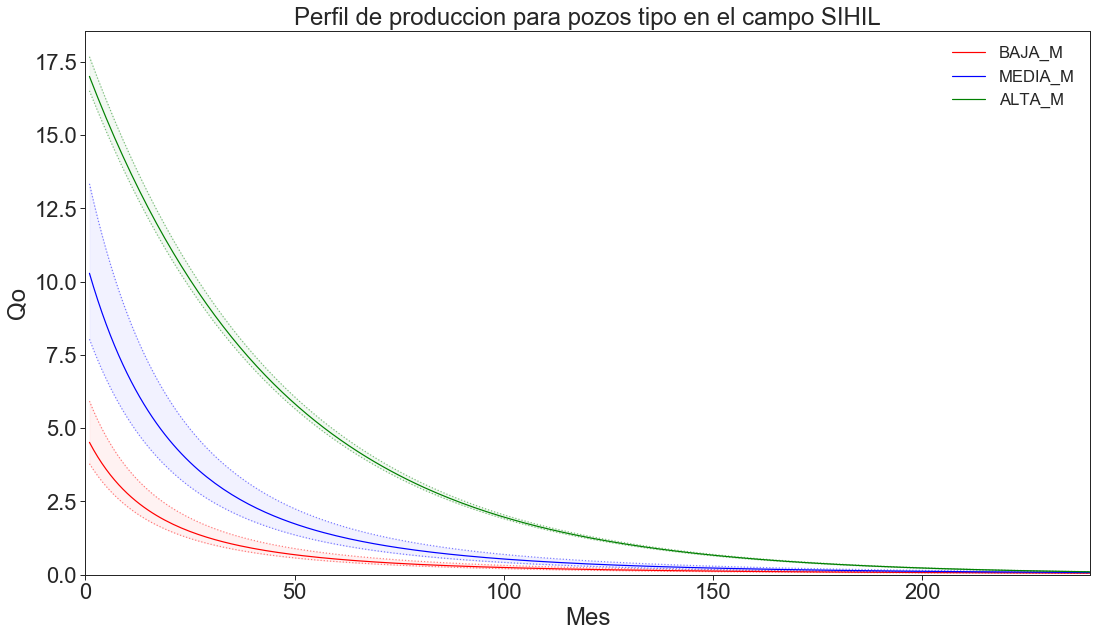

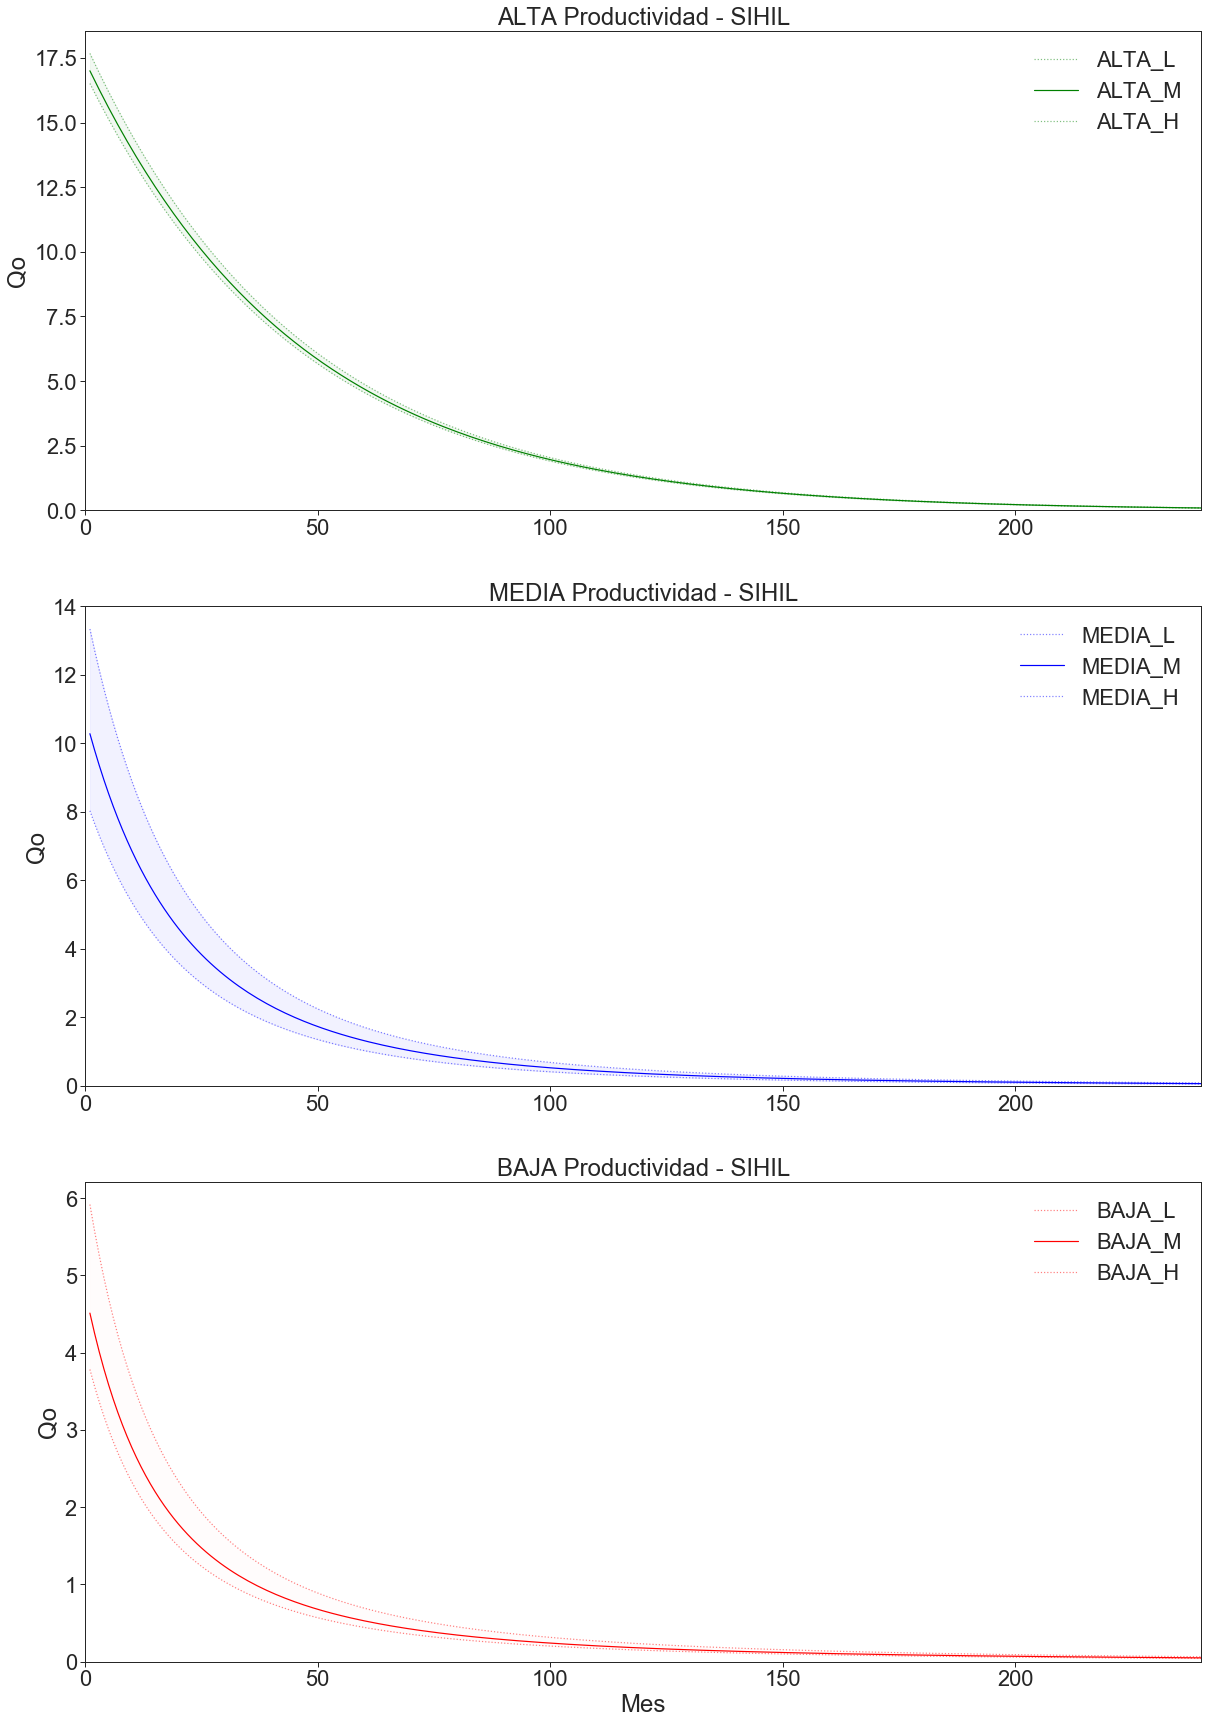

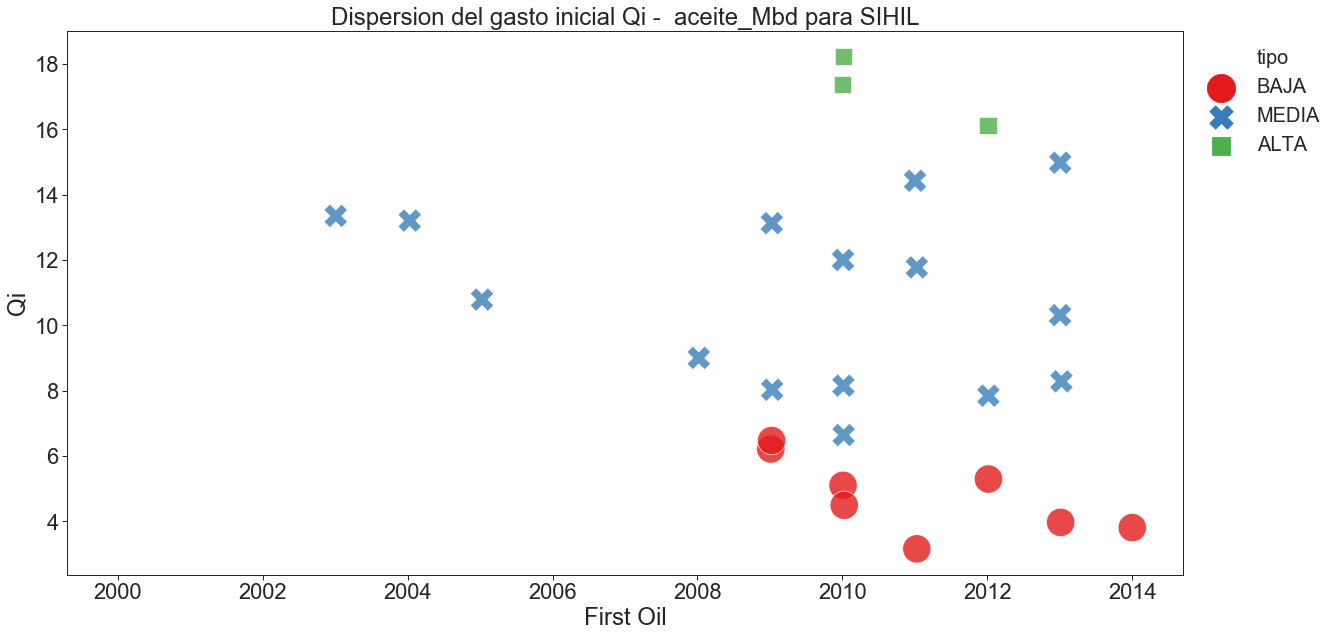

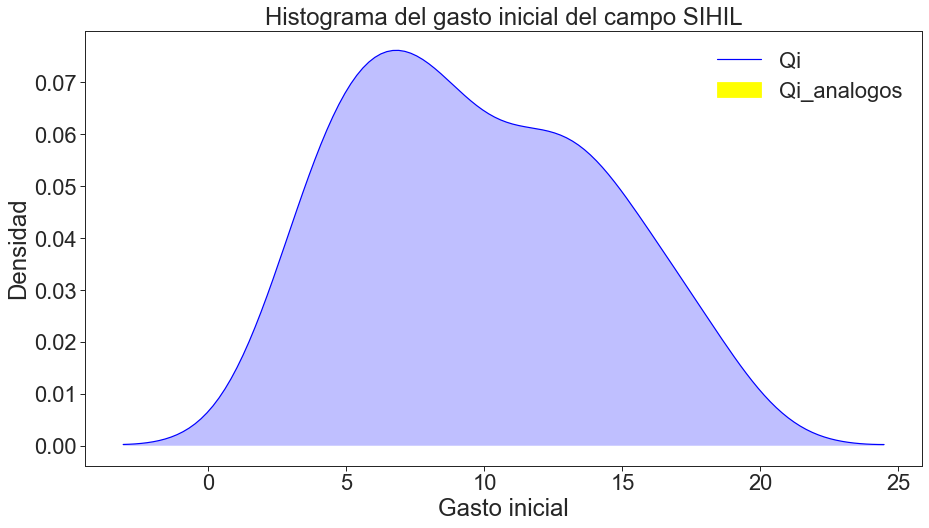

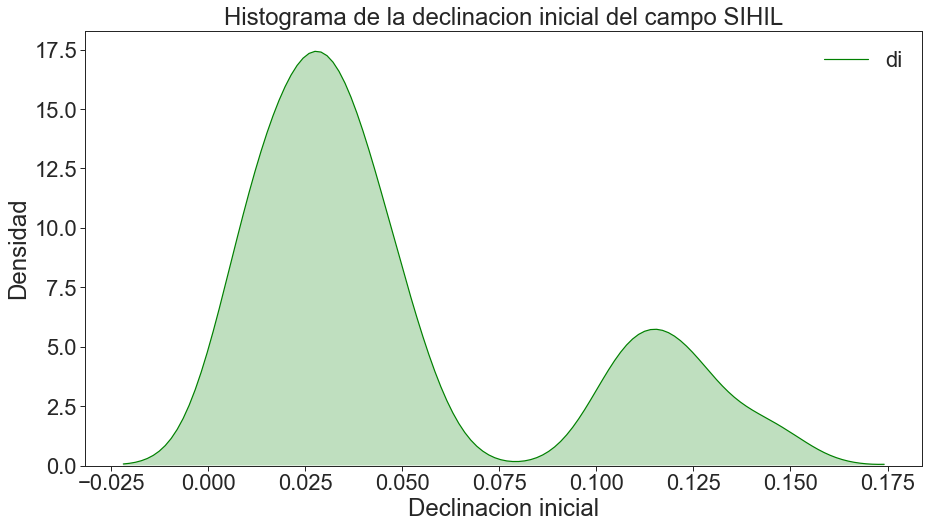

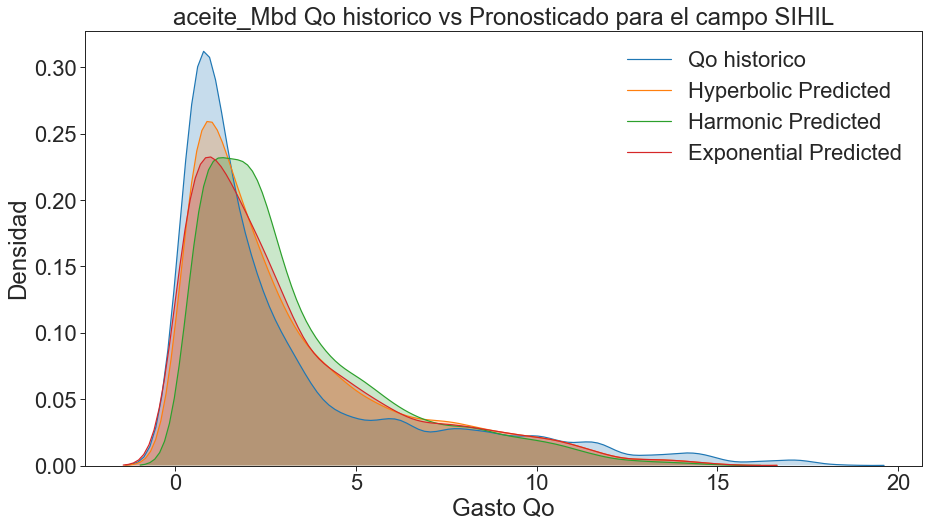

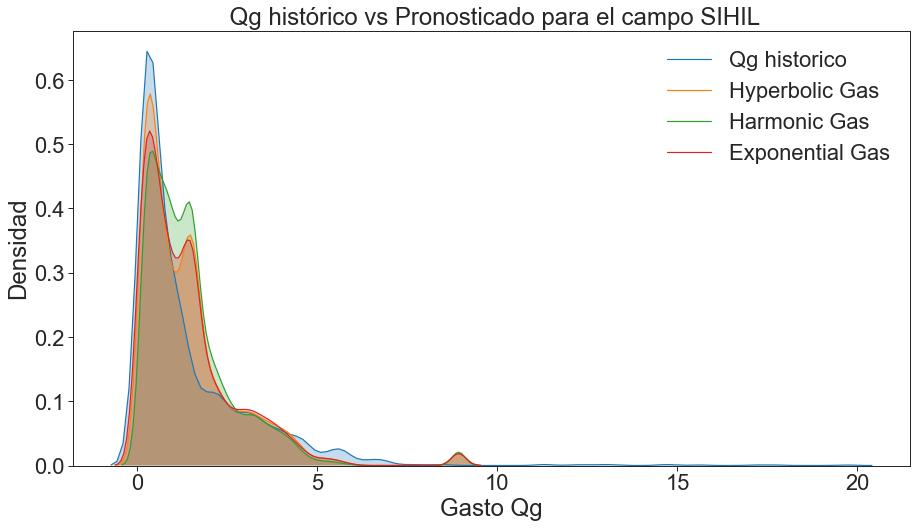

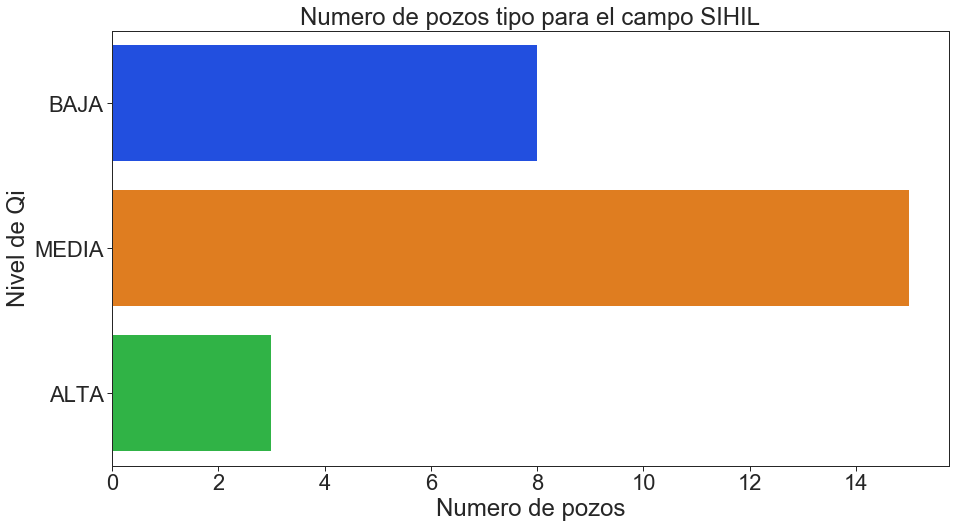

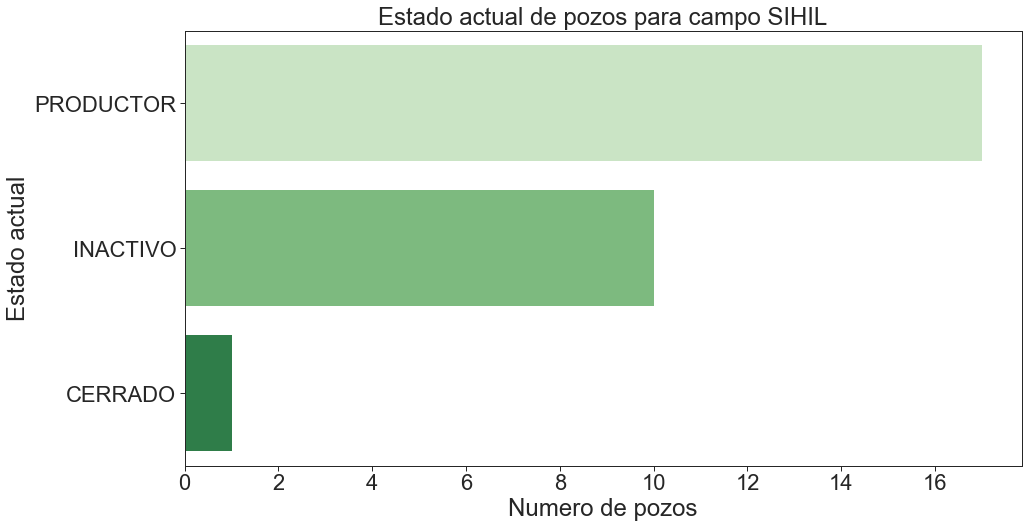

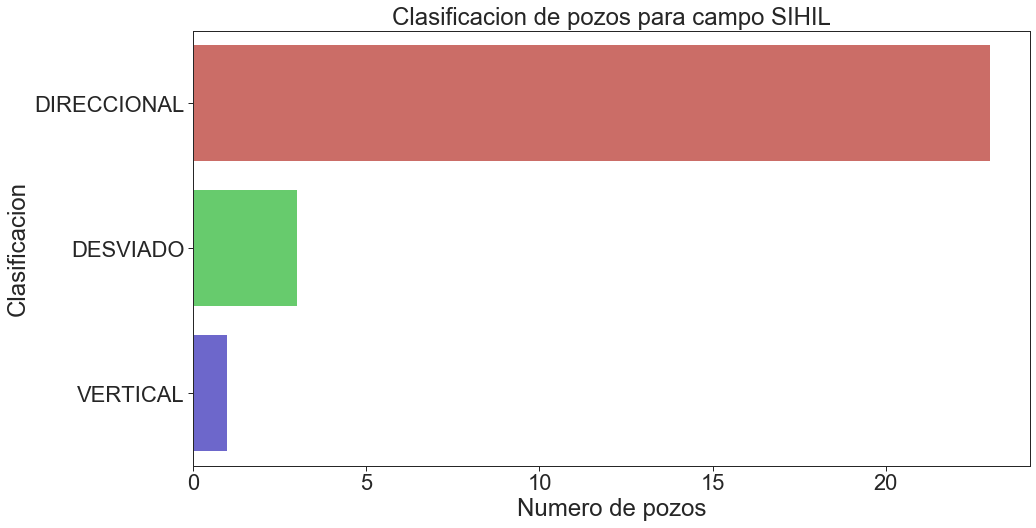

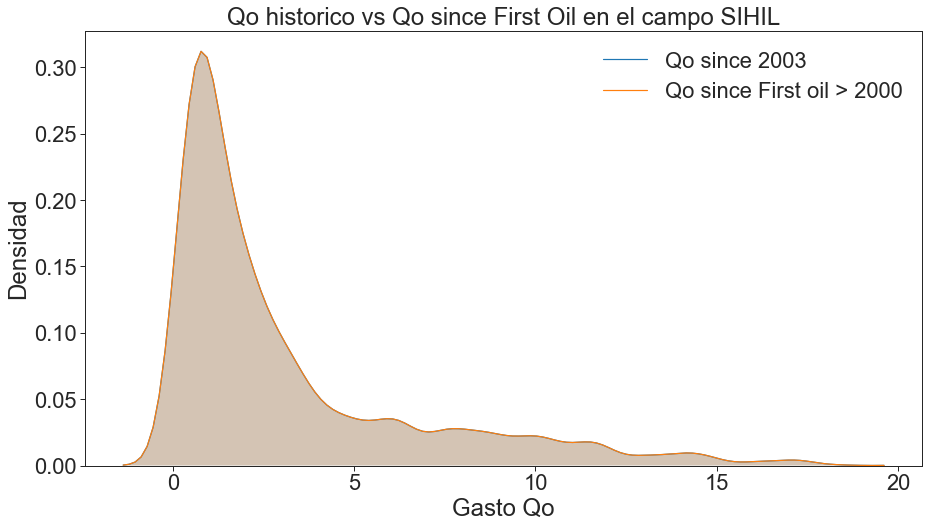

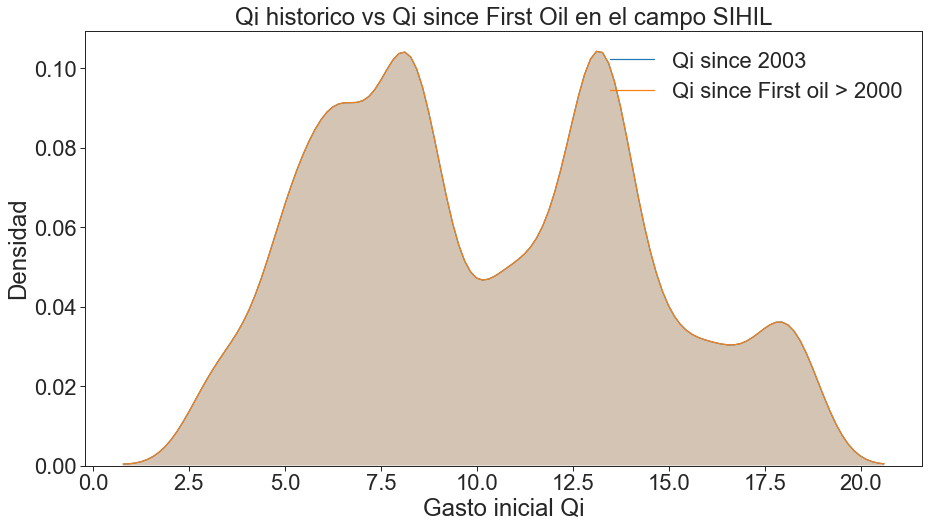

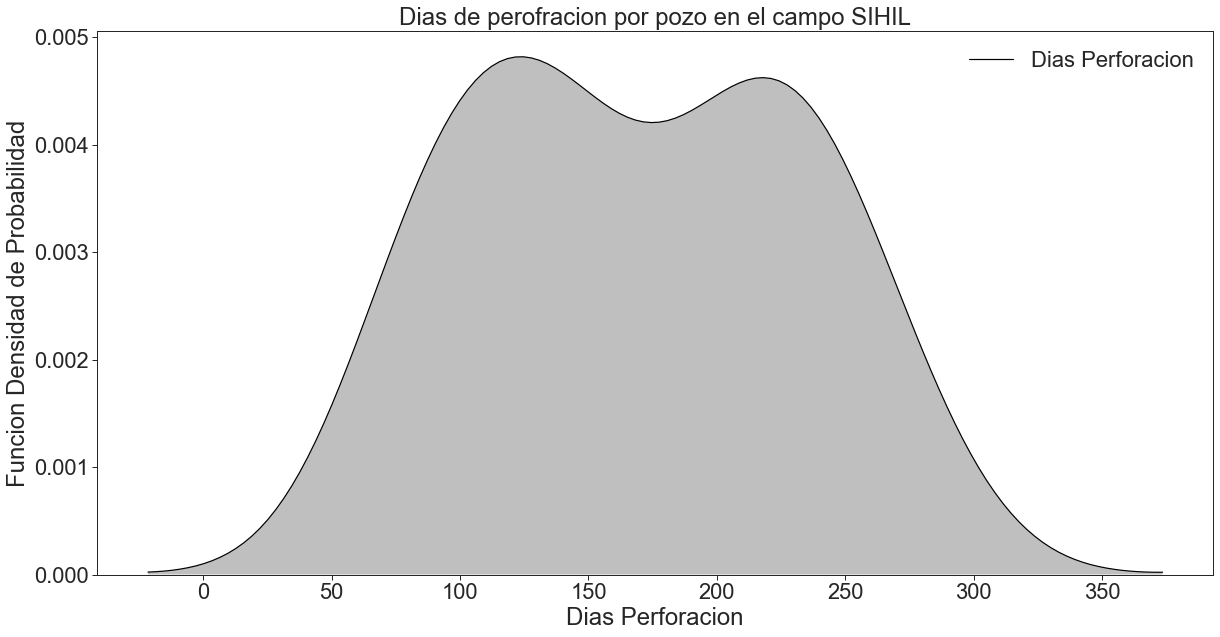

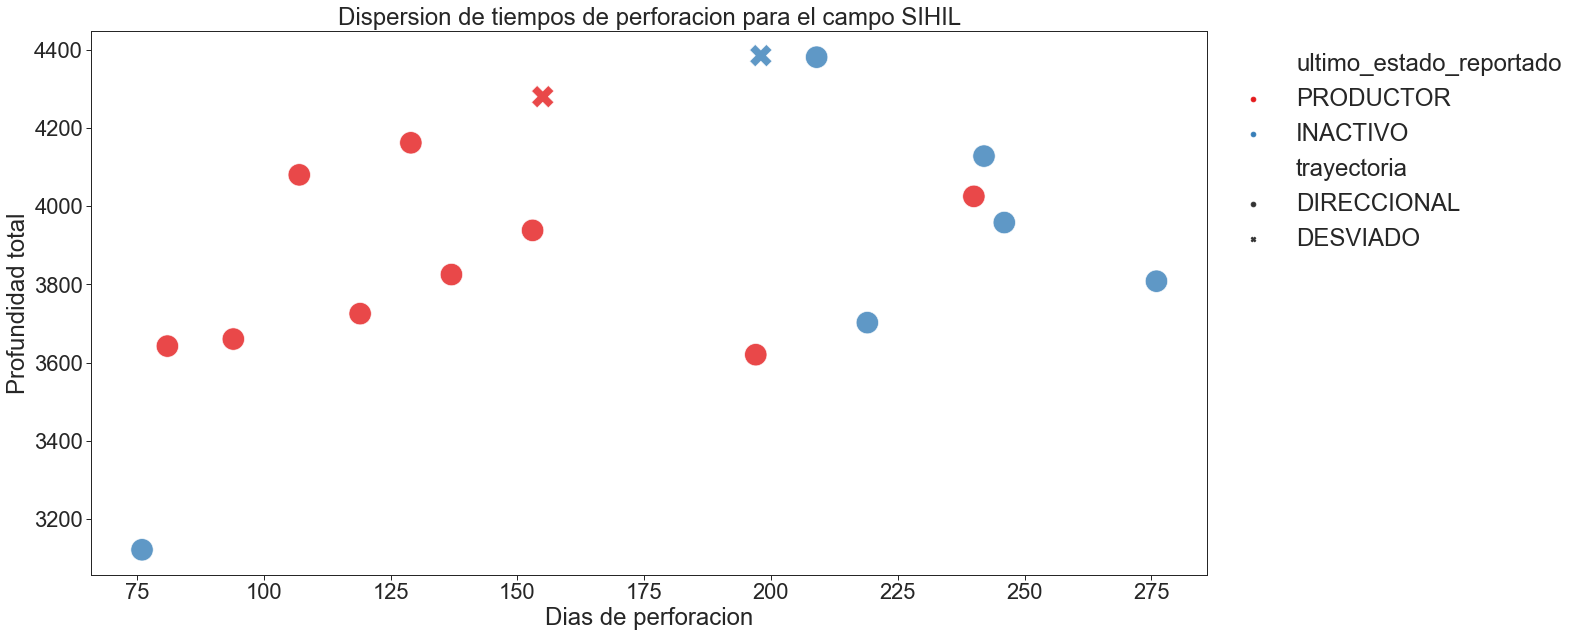

In [47]:
productividad()
#display(info_reservas)
#display(serie_base)
#display(len(lista_pozos),len(unique_well_list))
#display(resumen_produccion, produccion_mensual.head(),serie_status)

In [ ]:
display(pozos.columns)

# Ejemplos

Nombre de campo: SIHIL


'Número de pozos en SIHIL: 28'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


produccion_mensual_campo_Mbd
fecha                                   
2012-01-11                        110.40

pozos_perforados                28.00
pozos_productores               26.00
pozos_secos                      2.00
exito_mecanico                   0.93
EUR_por_pozo_MMb                 8.04
pozos_activos                   16.00
pozos_cerrados                  10.00
produccion_media_Mbd             1.70
produccion_mensual_max_MMb      18.24
EUR_max_MMb                     25.59
EUR_min_MMb                      0.00
Q_base                          17.87
Qg_base                         12.47
Qc_base                          0.00
Np                             229.63
Gp                              95.82
Cp                               0.00
Wp                              64.31
OOIP                         1,461.64
Fr_aceite                        0.16
OGIP                           436.24
Fr_gas                           0.22
Name: SIHIL, dtype: float64

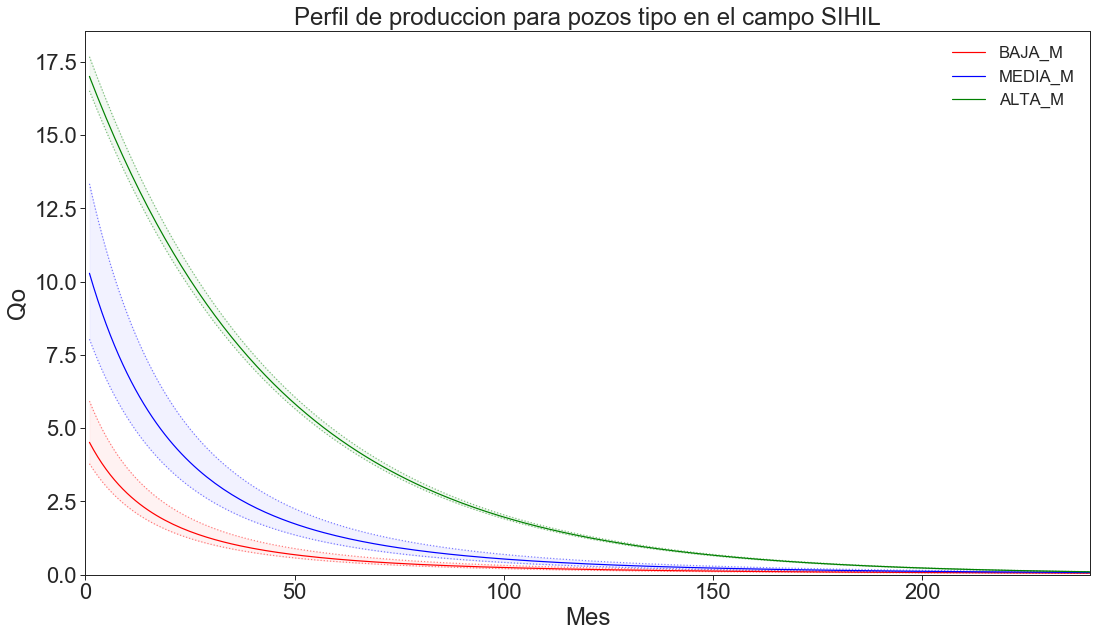

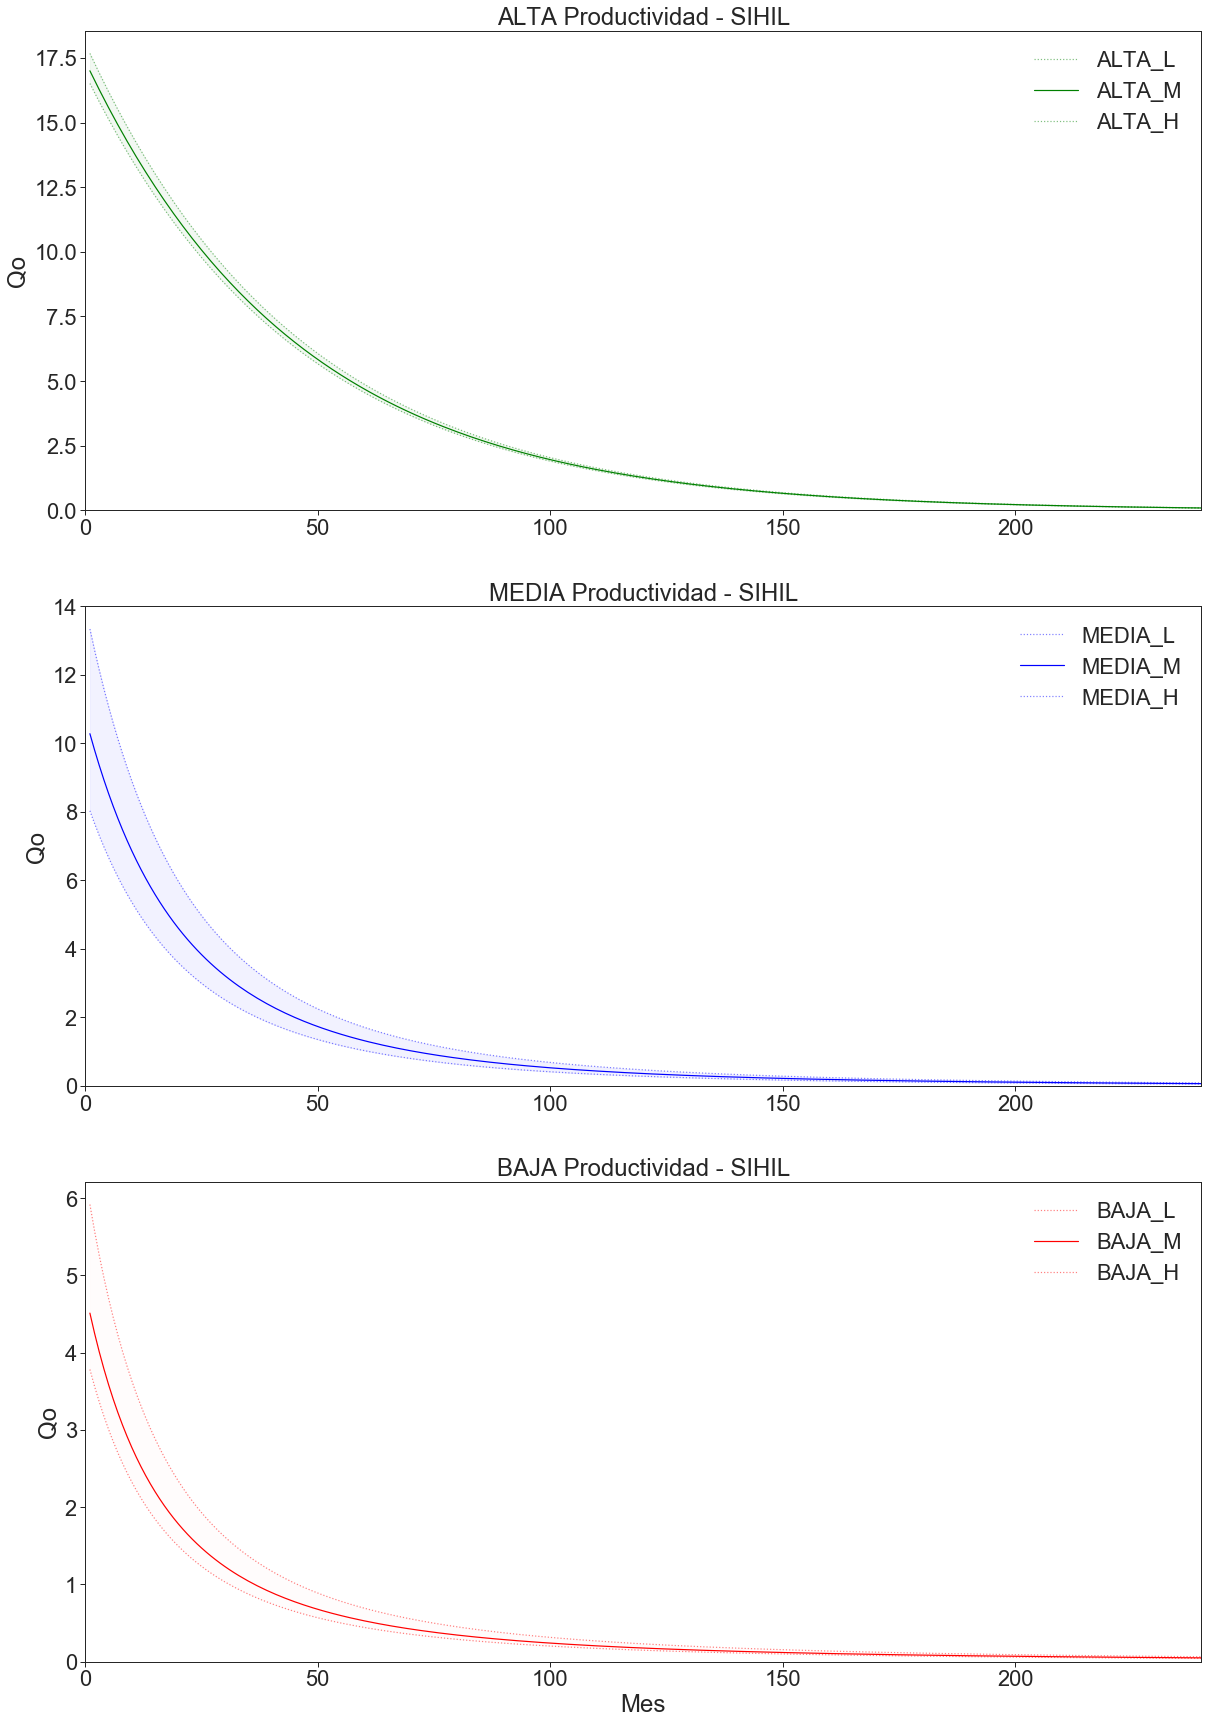

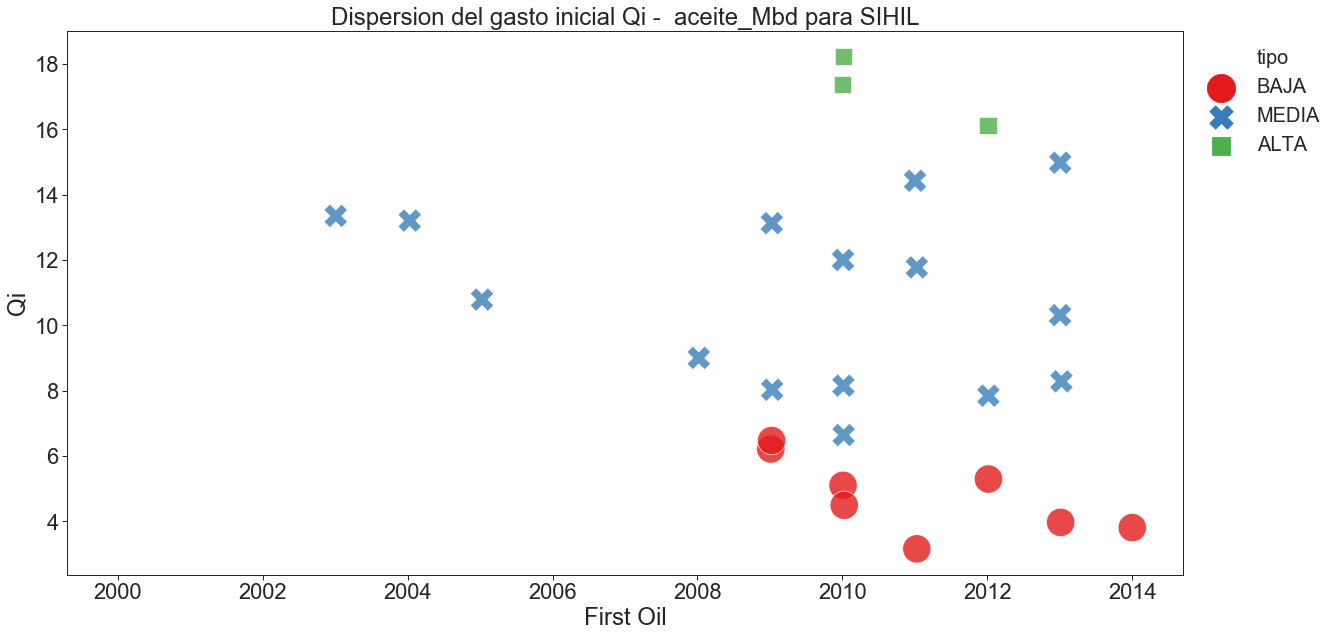

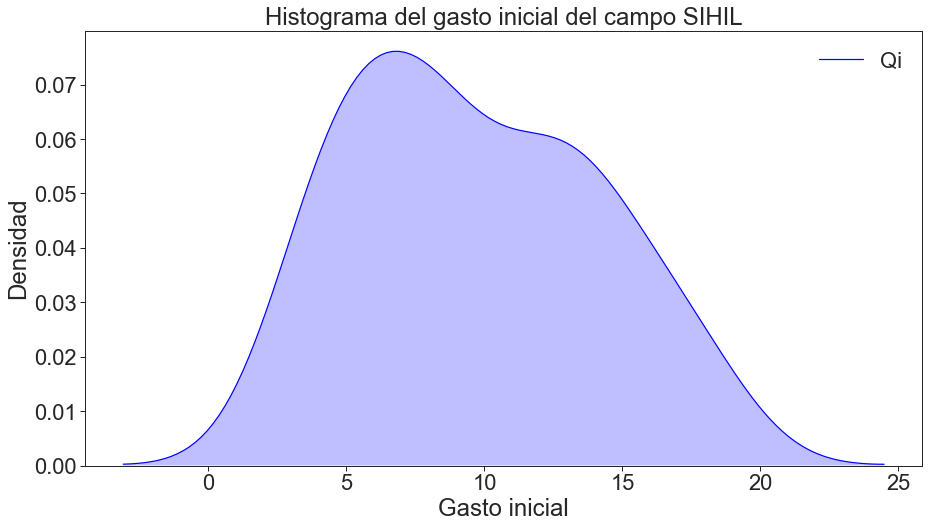

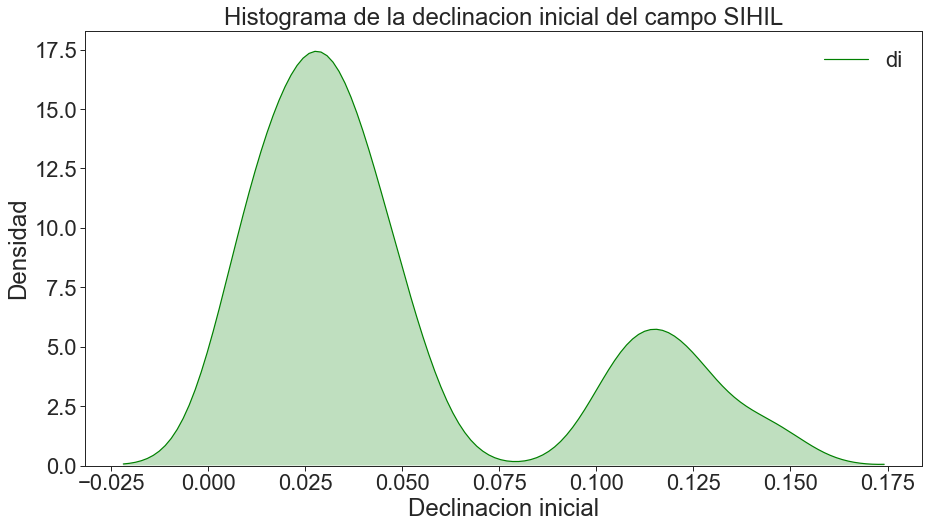

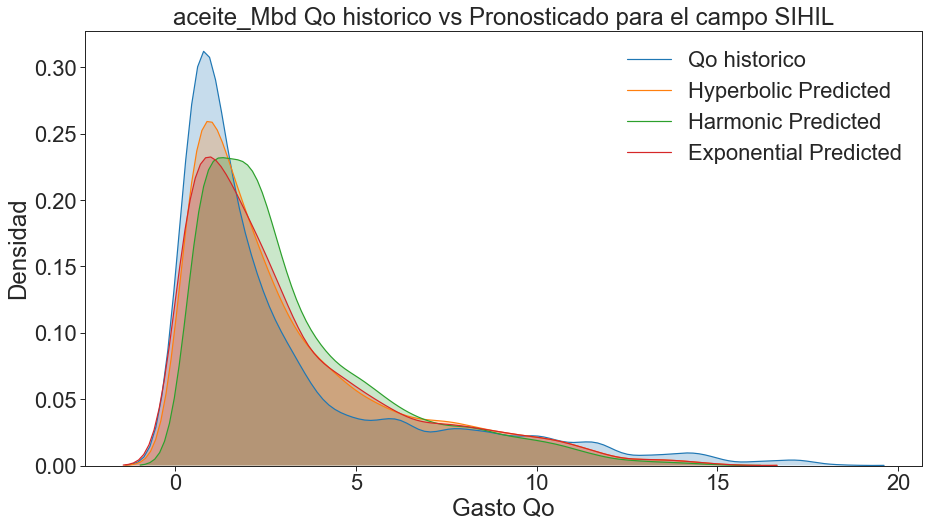

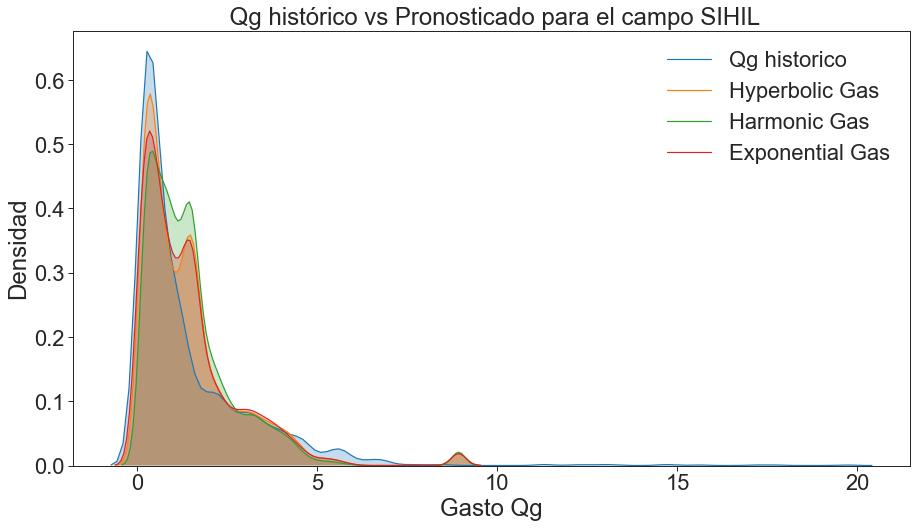

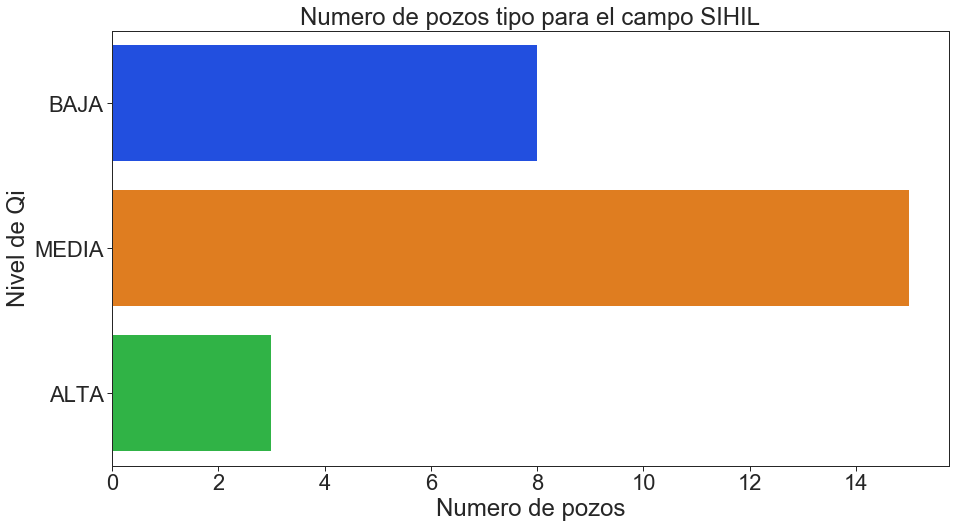

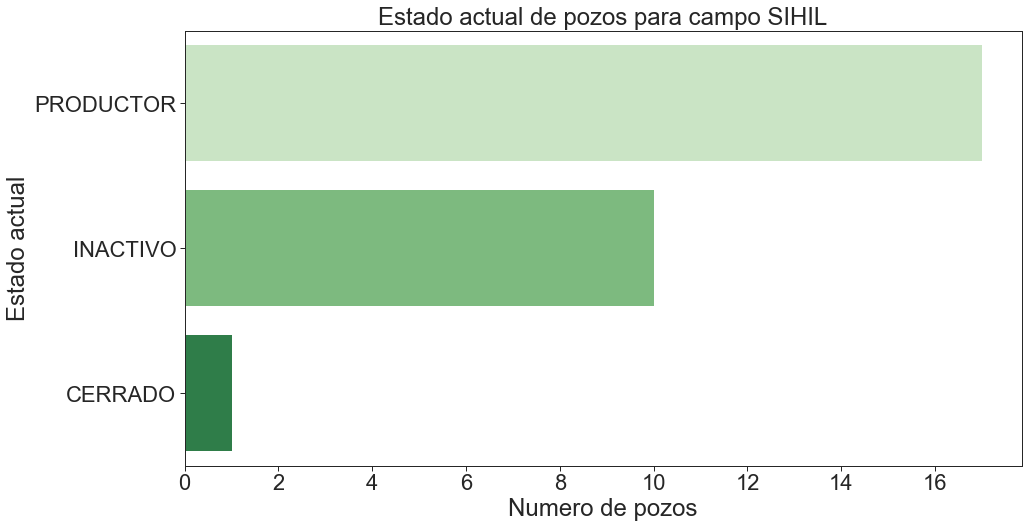

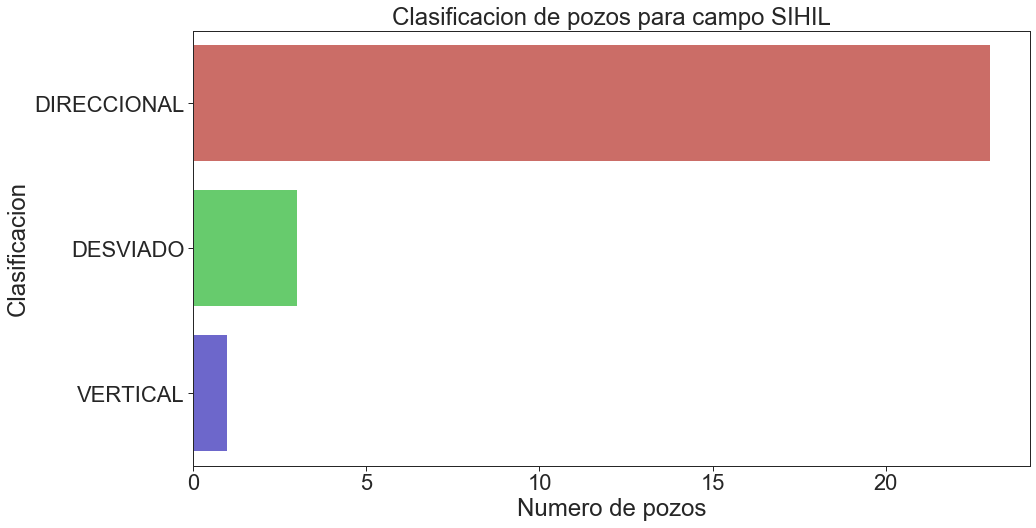

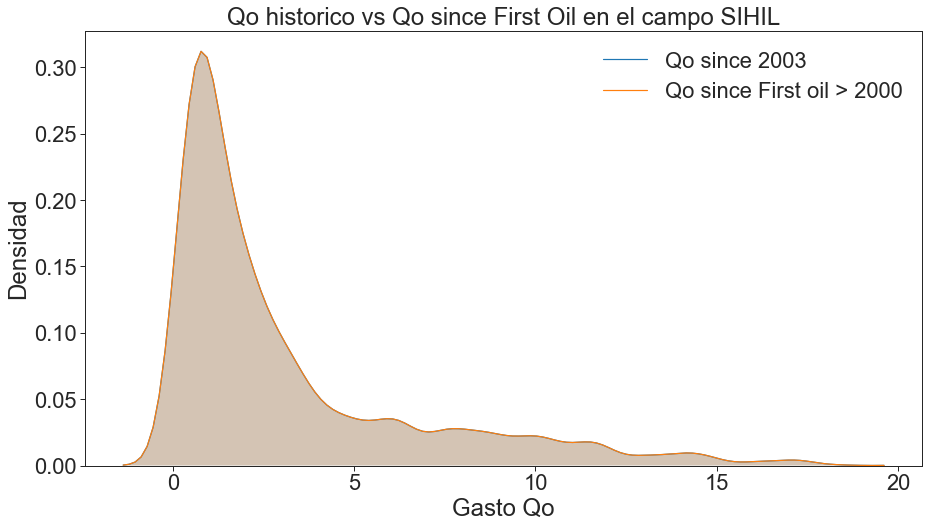

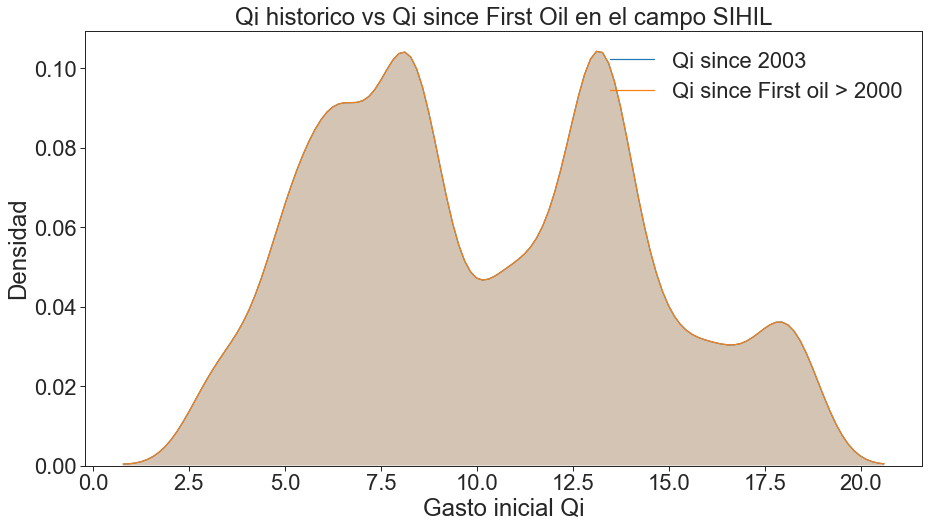

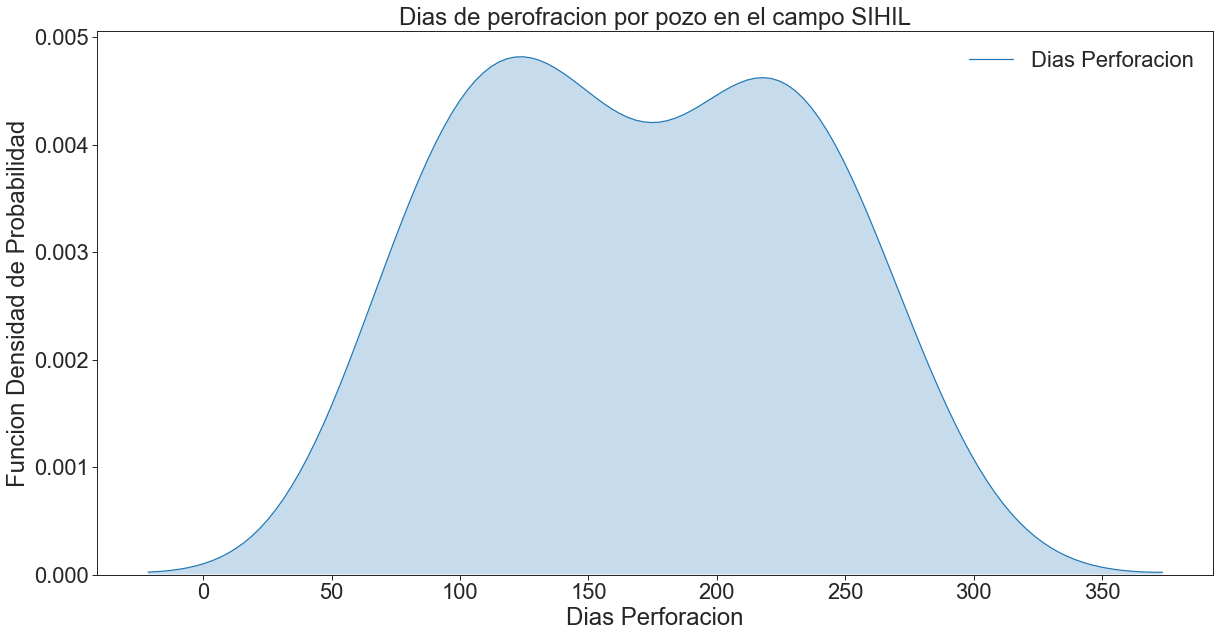

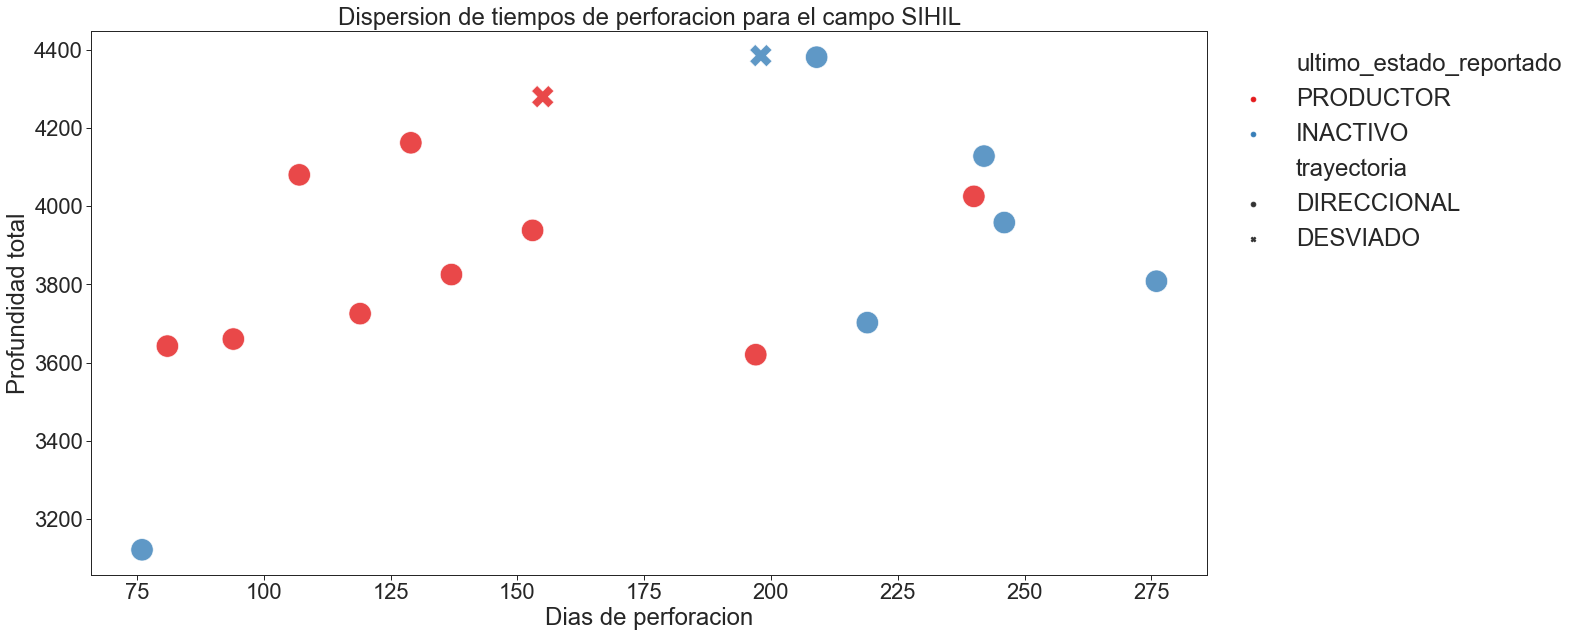

In [21]:
productividad()

Nombre de campo: EK


'Número de pozos en EK: 27'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


produccion_mensual_campo_Mbd
fecha                                   
2013-01-10                         52.79

pozos_perforados                27.00
pozos_productores               22.00
pozos_secos                      5.00
exito_mecanico                   0.81
EUR_por_pozo_MMb                 7.40
pozos_activos                   12.00
pozos_cerrados                  10.00
produccion_media_Mbd             1.95
produccion_mensual_max_MMb      11.11
EUR_max_MMb                     18.37
EUR_min_MMb                      0.00
Q_base                          13.34
Qg_base                          1.32
Qc_base                          0.00
Np                             170.99
Gp                              15.69
Cp                               0.00
Wp                              80.95
OOIP                         1,017.56
Fr_aceite                        0.17
OGIP                           111.34
Fr_gas                           0.14
Name: EK, dtype: float64

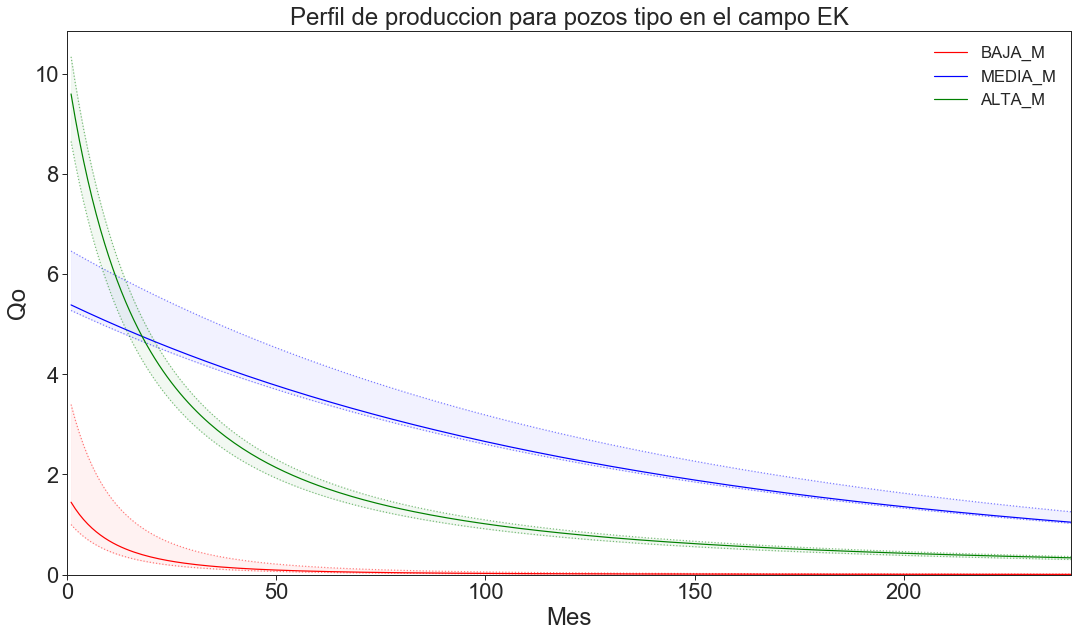

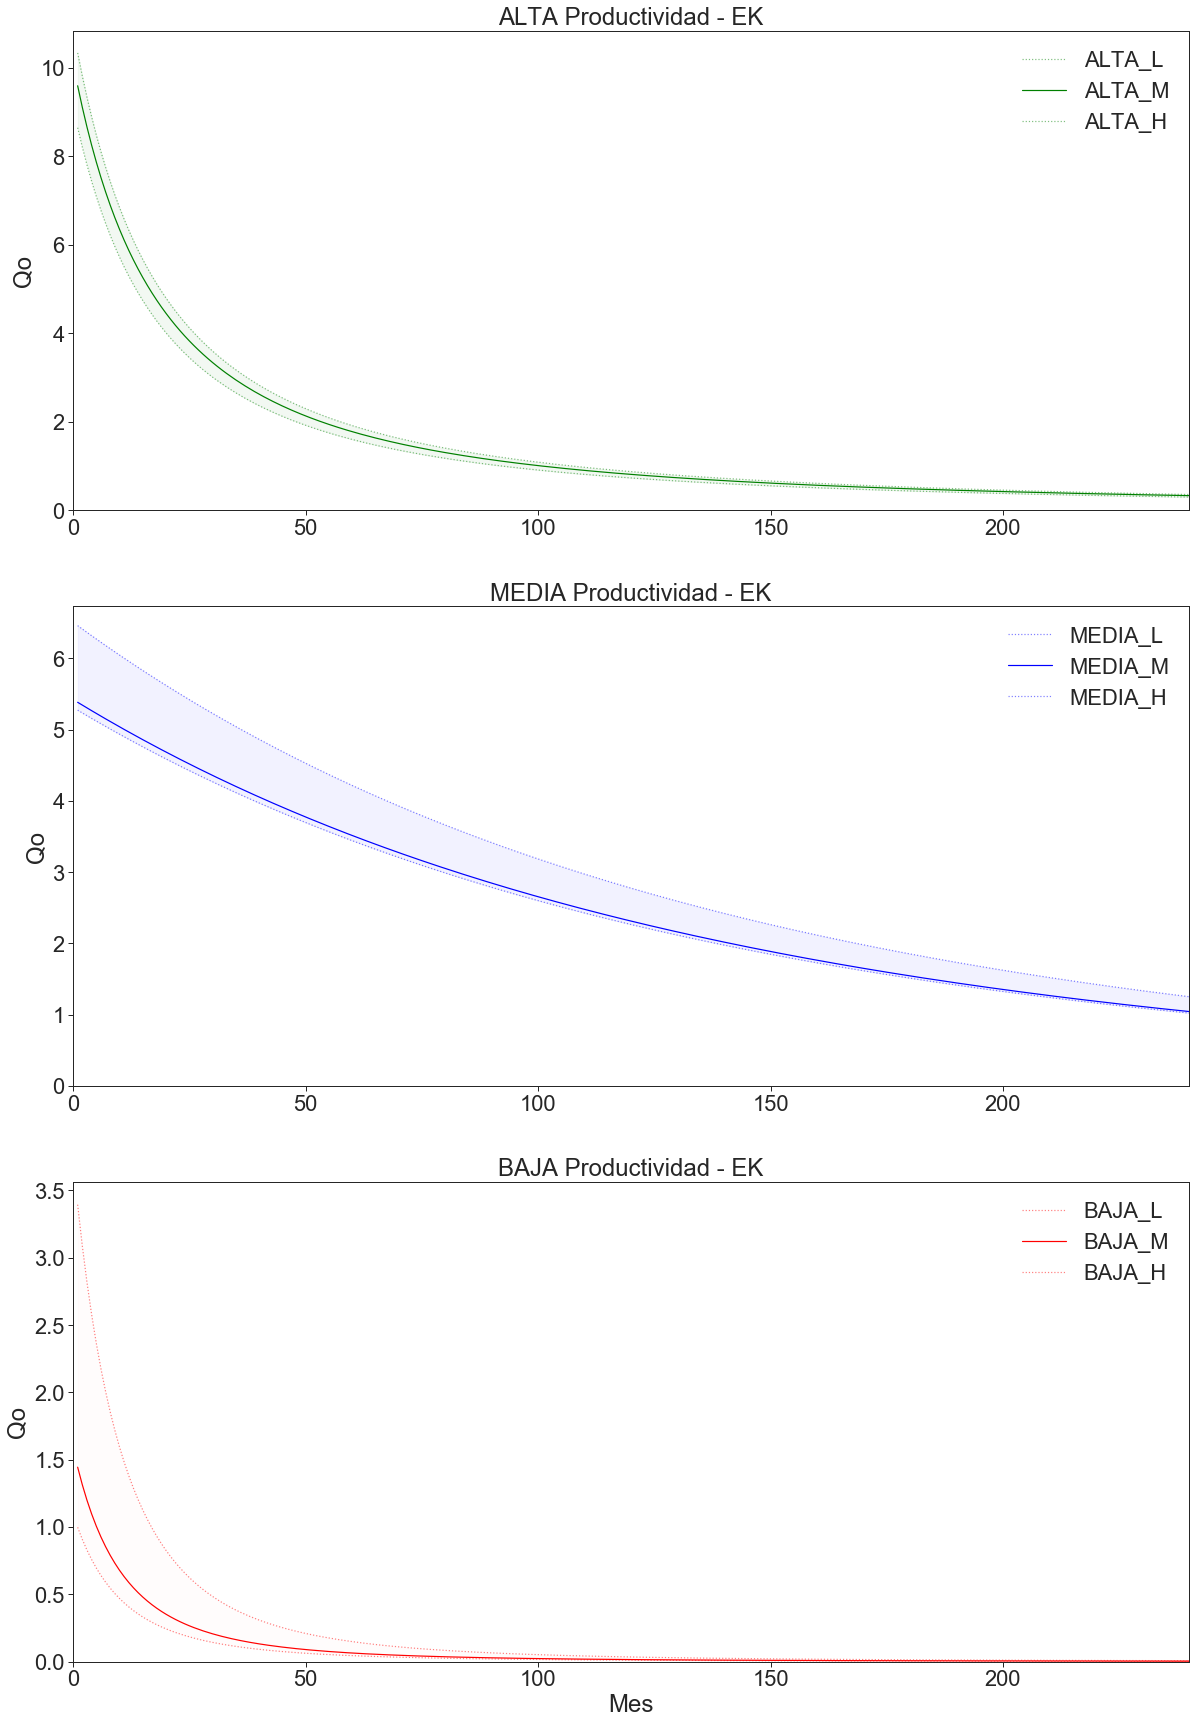

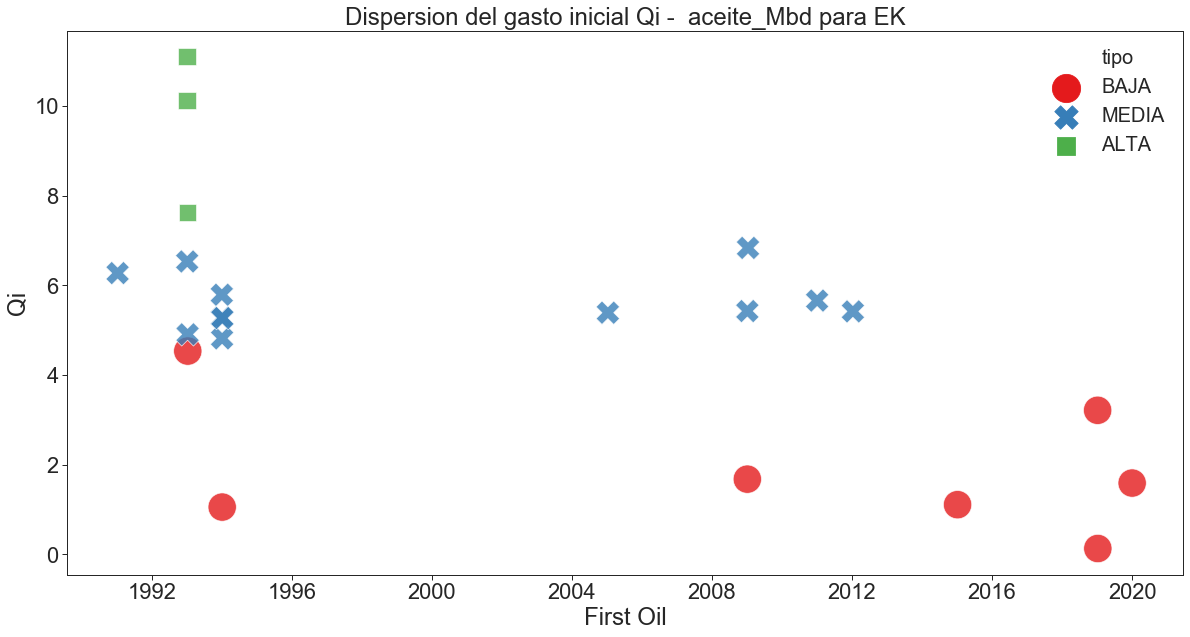

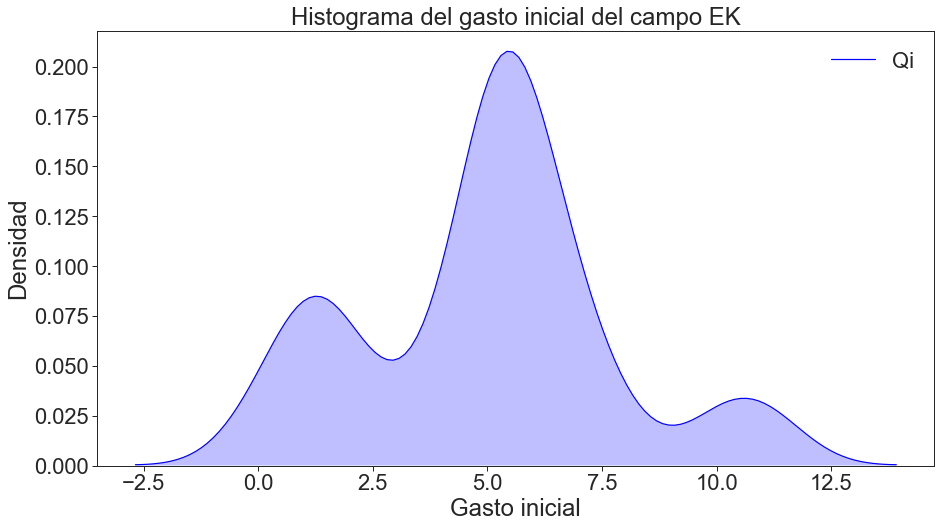

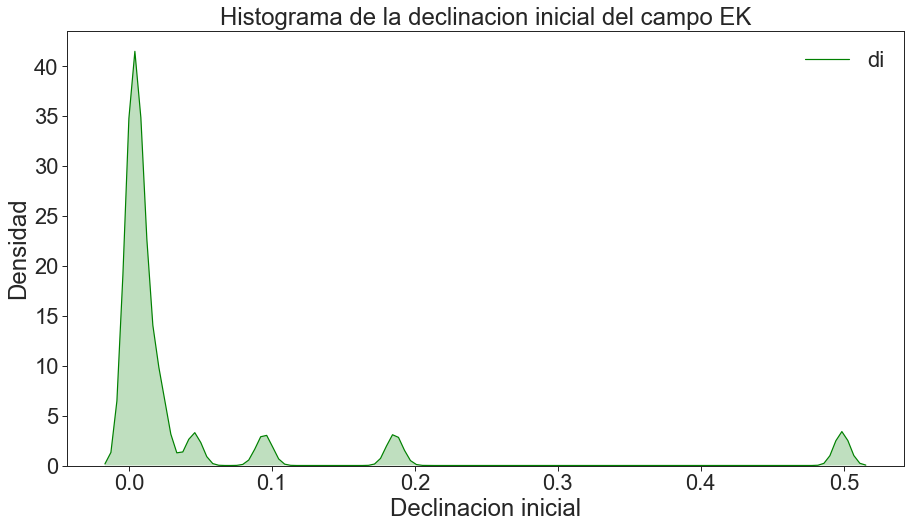

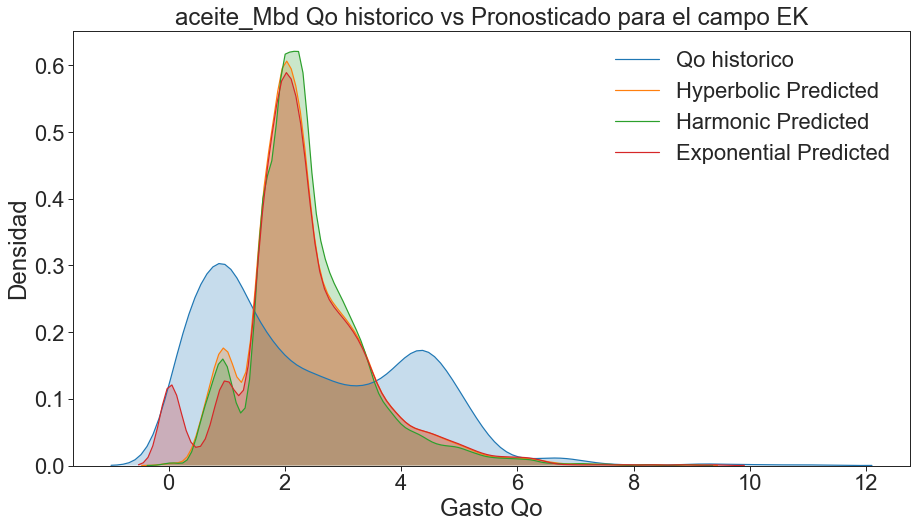

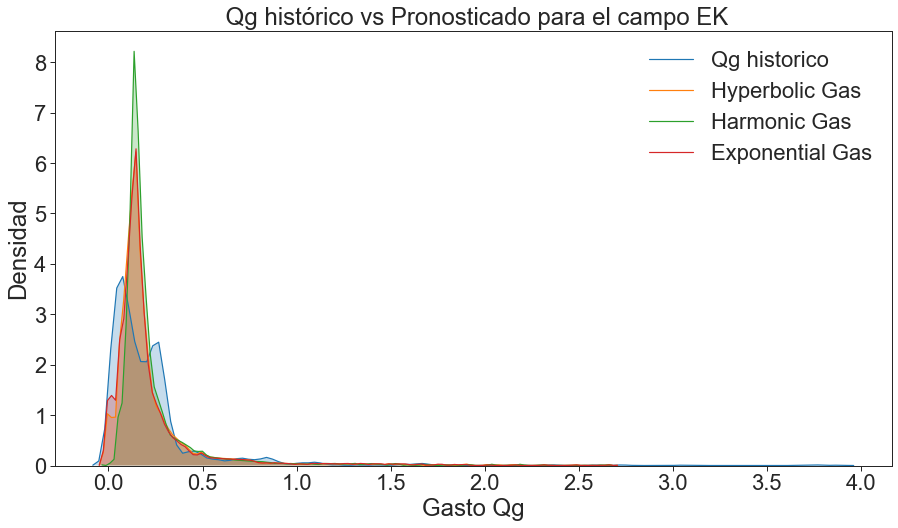

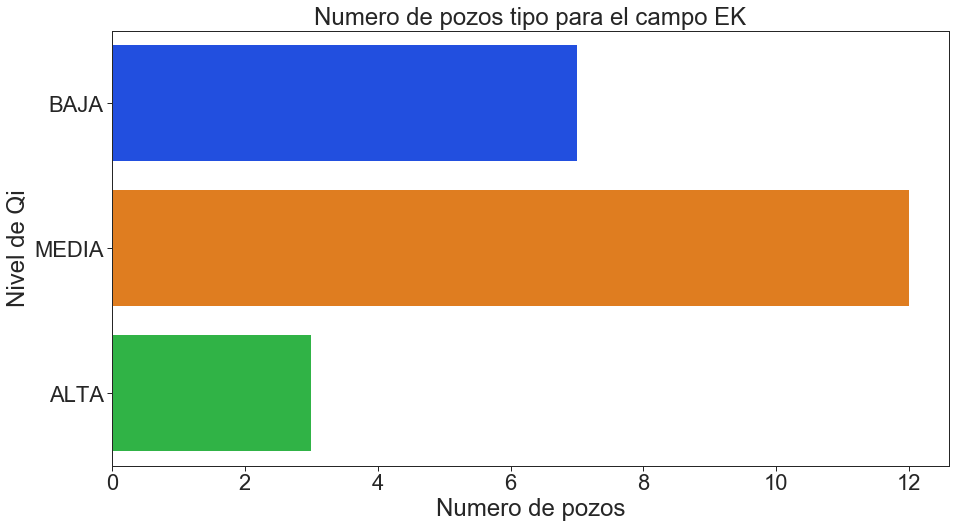

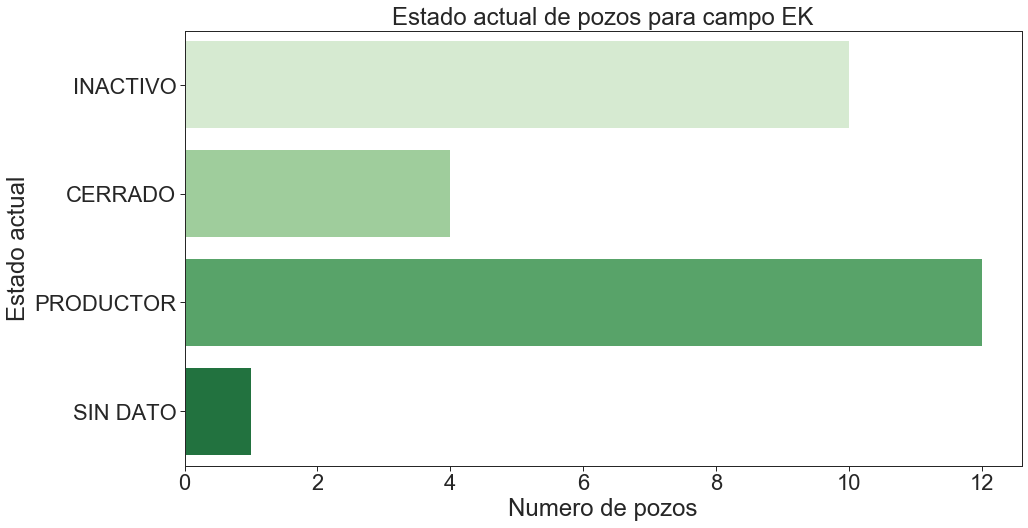

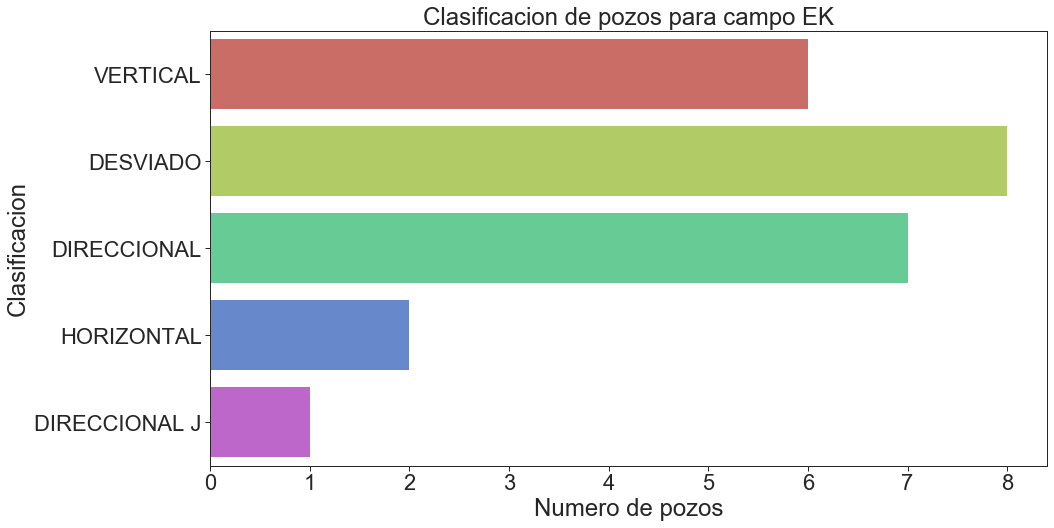

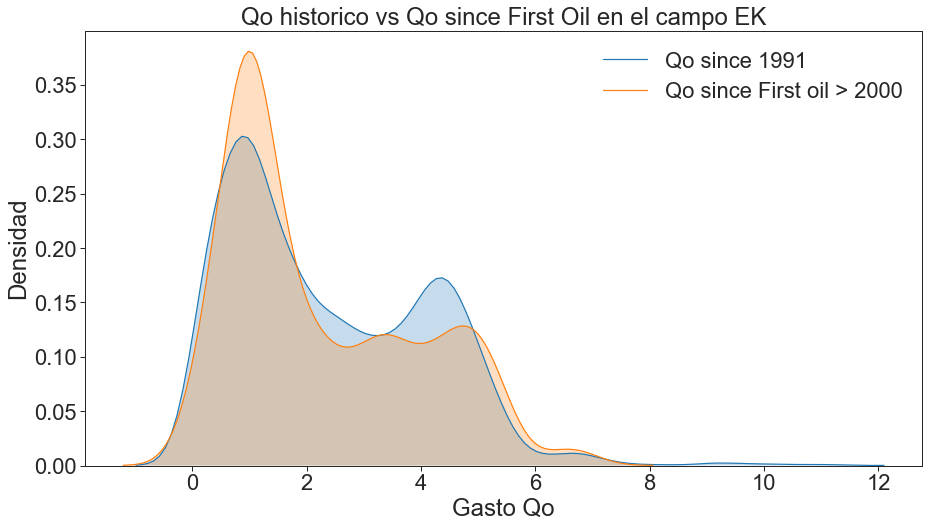

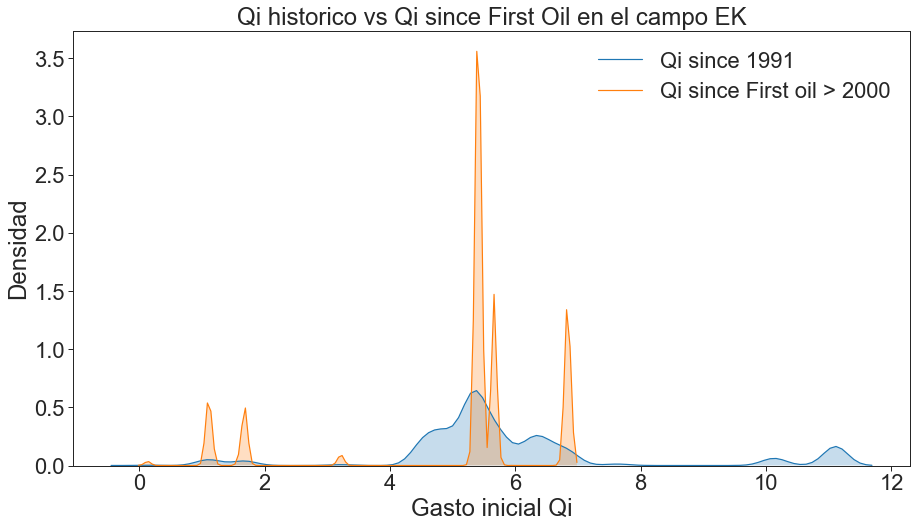

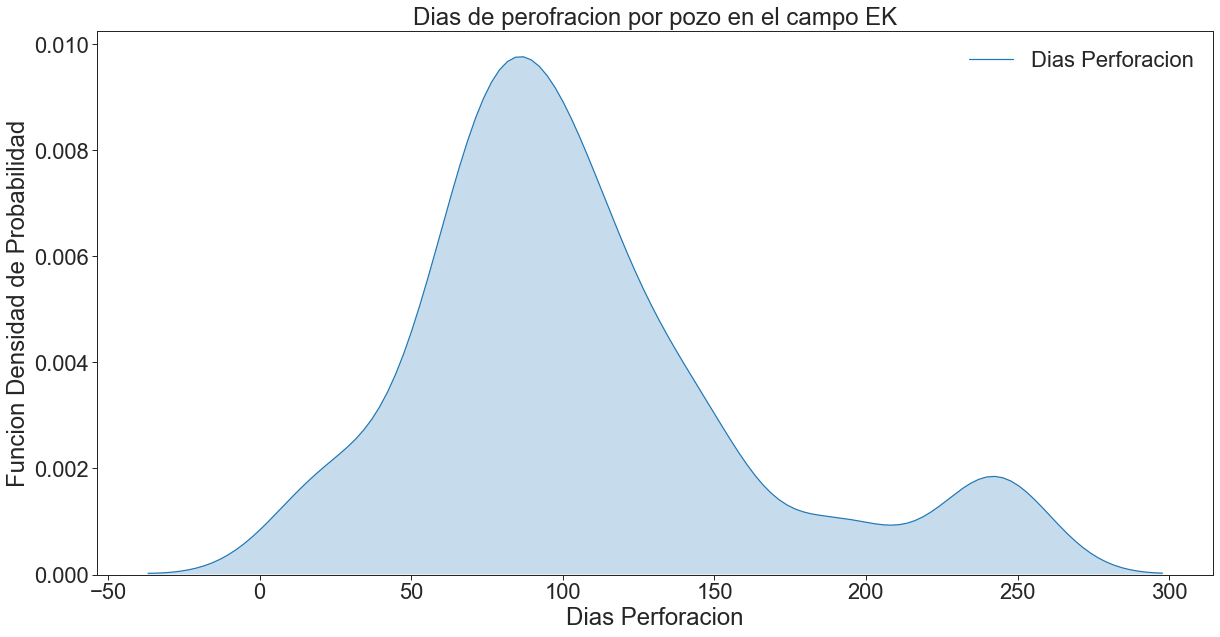

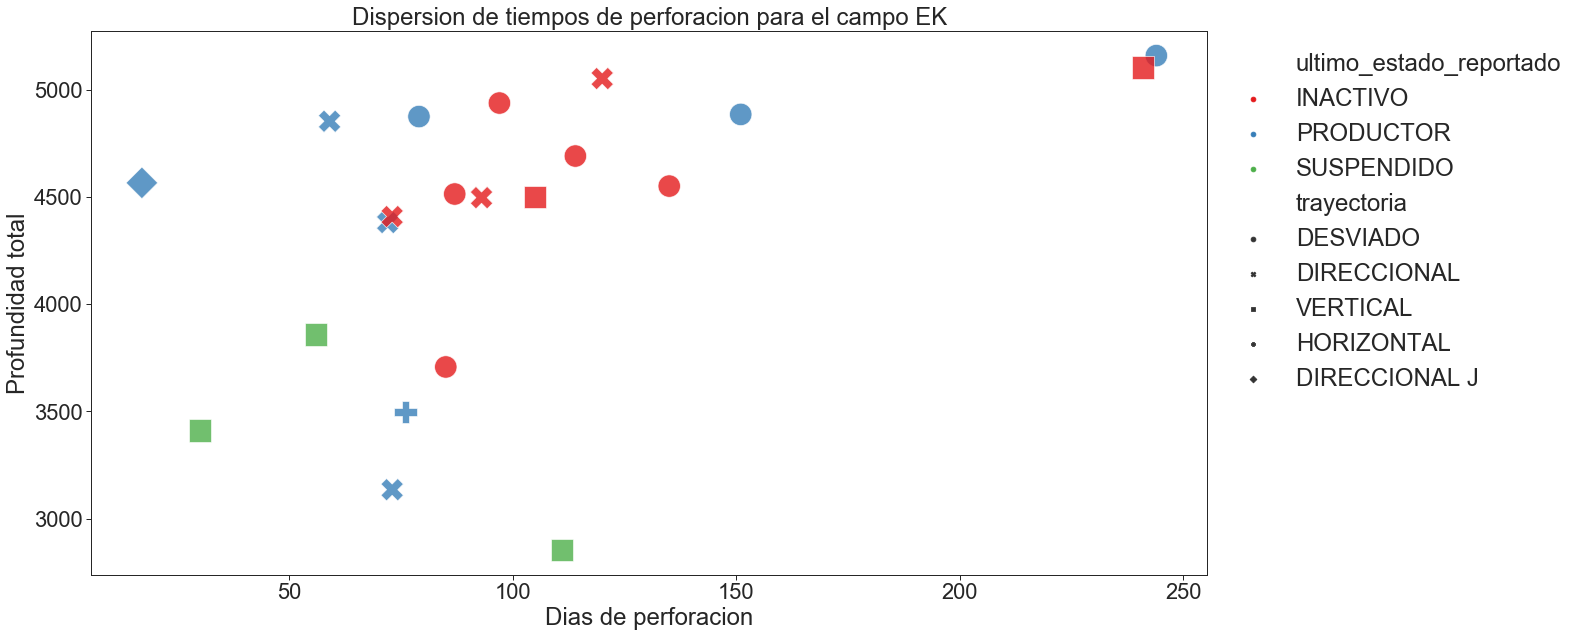

In [20]:
productividad()

In [18]:
display(tipo1.describe(),
       tipo2.describe(),
       tipo3.describe())

Qi_hist  Qi_hyp    b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count     3.00    3.00 3.00    3.00          3.00          3.00     3.00     3.00           3.00           3.00    3.00    3.00          3.00          3.00               3.00     3.00                  2.00    3.00   3.00    3.00           3.00          3.00           3.00
mean      1.93    1.65 0.60    0.05          0.37          8.37     1.64     0.06           0.28           0.04    1.64    0.04          0.24          0.02               0.62    14.00              4,675.05    0.58   0.67    0.04           0.00          0.50           5.00
std       0.37    0.49 0.53    0.04          0.07          9.91     0.48     0.04           0.13           0.01    0.50    0.03          0.11          0.01               0.04     1.73                127.21    0.24   0.58    0.01           0.00          0.00           0.00
min       1.54    1.09 0.00    0.02          0.30          2.15     1.09     0.02           0.18           0.02    1.06    0.02          0.16          0.02               0.58    13.00              4,585.10    0.40   0.00    0.03           0.00          0.50           5.00
25%       1.76    1.48 0.40    0.03          0.35          2.66     1.47     0.03           0.21           0.03    1.47    0.03          0.18          0.02               0.60    13.00              4,630.08    0.44   0.50    0.03           0.00          0.50           5.00
50%       1.97    1.88 0.80    0.04          0.40          3.17     1.86     0.04           0.25           0.04    1.88    0.04          0.19          0.02               0.63    13.00              4,675.05    0.49   1.00    0.04           0.00          0.50           5.00
75%       2.13    1.93 0.90    0.07          0.41         11.49     1.92     0.08           0.34           0.04    1.93    0.06          0.28          0.02               0.64    14.50              4,720.02    0.67   1.00    0.05           0.00          0.50           5.00
max       2.28    1.97 1.00    0.10          0.42         19.80     1.97     0.11           0.43           0.05    1.97    0.08          0.37          0.03               0.66    16.00              4,765.00    0.85   1.00    0.05           0.00          0.50           5.00

Qi_hist  Qi_hyp    b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count     5.00    5.00 5.00    5.00          5.00          5.00     5.00     5.00           5.00           5.00    5.00    5.00          5.00          5.00               5.00     5.00                  4.00    5.00   5.00    5.00           5.00          5.00           5.00
mean      5.25    3.21 0.55    0.02          0.25          0.56     3.21     0.02           0.23           0.00    2.64    0.01          0.14          0.00               0.73   186.80              3,533.97    1.28   0.55    0.05           0.00          0.50           5.00
std       2.47    1.61 0.51    0.04          0.24          1.08     1.61     0.04           0.17           0.01    1.29    0.01          0.06          0.00               0.73    98.30                426.89    0.86   0.51    0.06           0.00          0.00           0.00
min       2.72    1.51 0.00    0.00          0.07          0.00     1.51     0.00           0.07           0.00    1.43    0.00          0.07          0.00               0.08    58.00              3,302.00    0.38   0.00    0.00           0.00          0.50           5.00
25%       2.96    1.85 0.00    0.00          0.15          0.04     1.85     0.00           0.13           0.00    1.85    0.00          0.11          0.00               0.30   132.00              3,321.43    0.38   0.00    0.01           0.00          0.50           5.00
50%       5.03    2.96 0.75    0.00          0.18          0.05     2.96     0.01           0.20           0.00    2.25    0.00          0.15          0.00               0.39   177.00              3,329.95    1.54   0.77    0.01           0.00          0.50           5.00
75%       7.70    4.71 1.00    0.02          0.19          0.23     4.70     0.02           0.24           0.00    2.96    0.01          0.19          0.00               1.00   272.00              3,542.50    1.86   1.00    0.10           0.00          0.50           5.00
max       7.85    5.03 1.00    0.09          0.67          2.49     5.03     0.09           0.52           0.02    4.71    0.02          0.21          0.00               1.89   295.00              4,174.00    2.26   1.00    0.13           0.00          0.50           5.00

Qi_hist  Qi_hyp    b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count     1.00    1.00 1.00    1.00          1.00          1.00     1.00     1.00           1.00           1.00    1.00    1.00          1.00          1.00               1.00     1.00                  1.00    1.00   1.00    1.00           1.00          1.00           1.00
mean     16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00
std        nan     nan  nan     nan           nan           nan      nan      nan            nan            nan     nan     nan           nan           nan                nan      nan                   nan     nan    nan     nan            nan           nan            nan
min      16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00
25%      16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00
50%      16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00
75%      16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00
max      16.90   11.89 0.33    0.02          0.81          0.16    12.45     0.04           0.92           0.01   11.42    0.02          0.57          0.00               0.86   259.00              5,000.00    5.51   0.00    0.02           0.00          0.50           5.00

Nombre de campo: SINAN


'Número de pozos en SINAN: 32'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


produccion_mensual_campo_Mbd
fecha                                   
2007-01-05                         73.26

pozos_perforados                32.00
pozos_productores               25.00
pozos_secos                      7.00
exito_mecanico                   0.78
EUR_por_pozo_MMb                 7.83
pozos_activos                    6.00
pozos_cerrados                  19.00
produccion_media_Mbd             2.36
produccion_mensual_max_MMb      15.69
EUR_max_MMb                     31.94
EUR_min_MMb                      0.00
Q_base                           4.12
Qg_base                          9.94
Qc_base                          0.00
Np                             198.57
Gp                             467.15
Cp                               0.00
Wp                              27.34
OOIP                           678.17
Fr_aceite                        0.29
OGIP                         1,612.30
Fr_gas                           0.29
Name: SINAN, dtype: float64

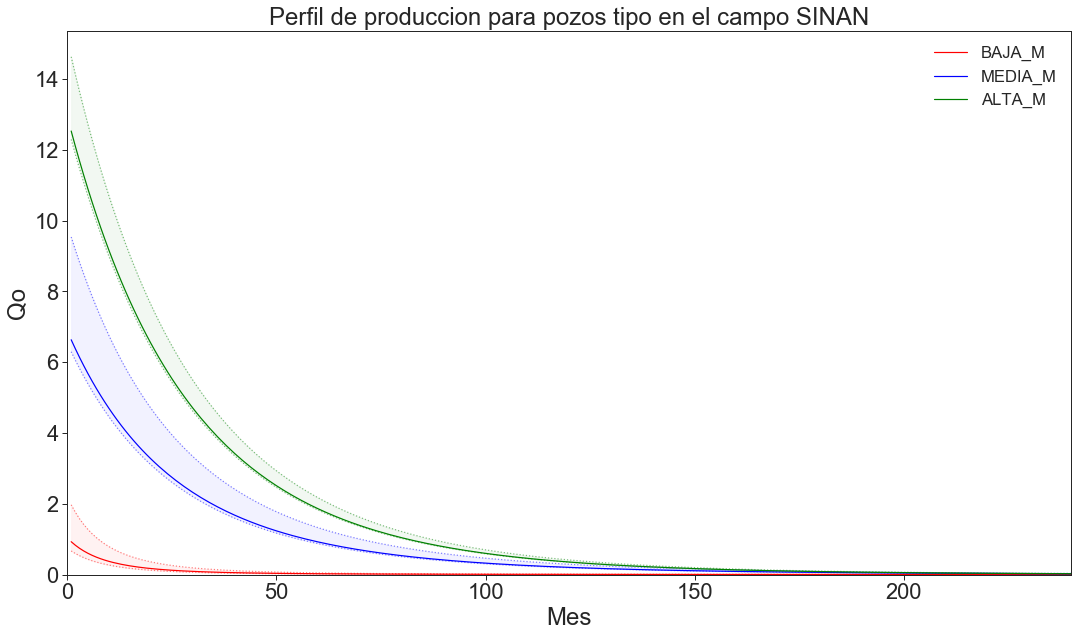

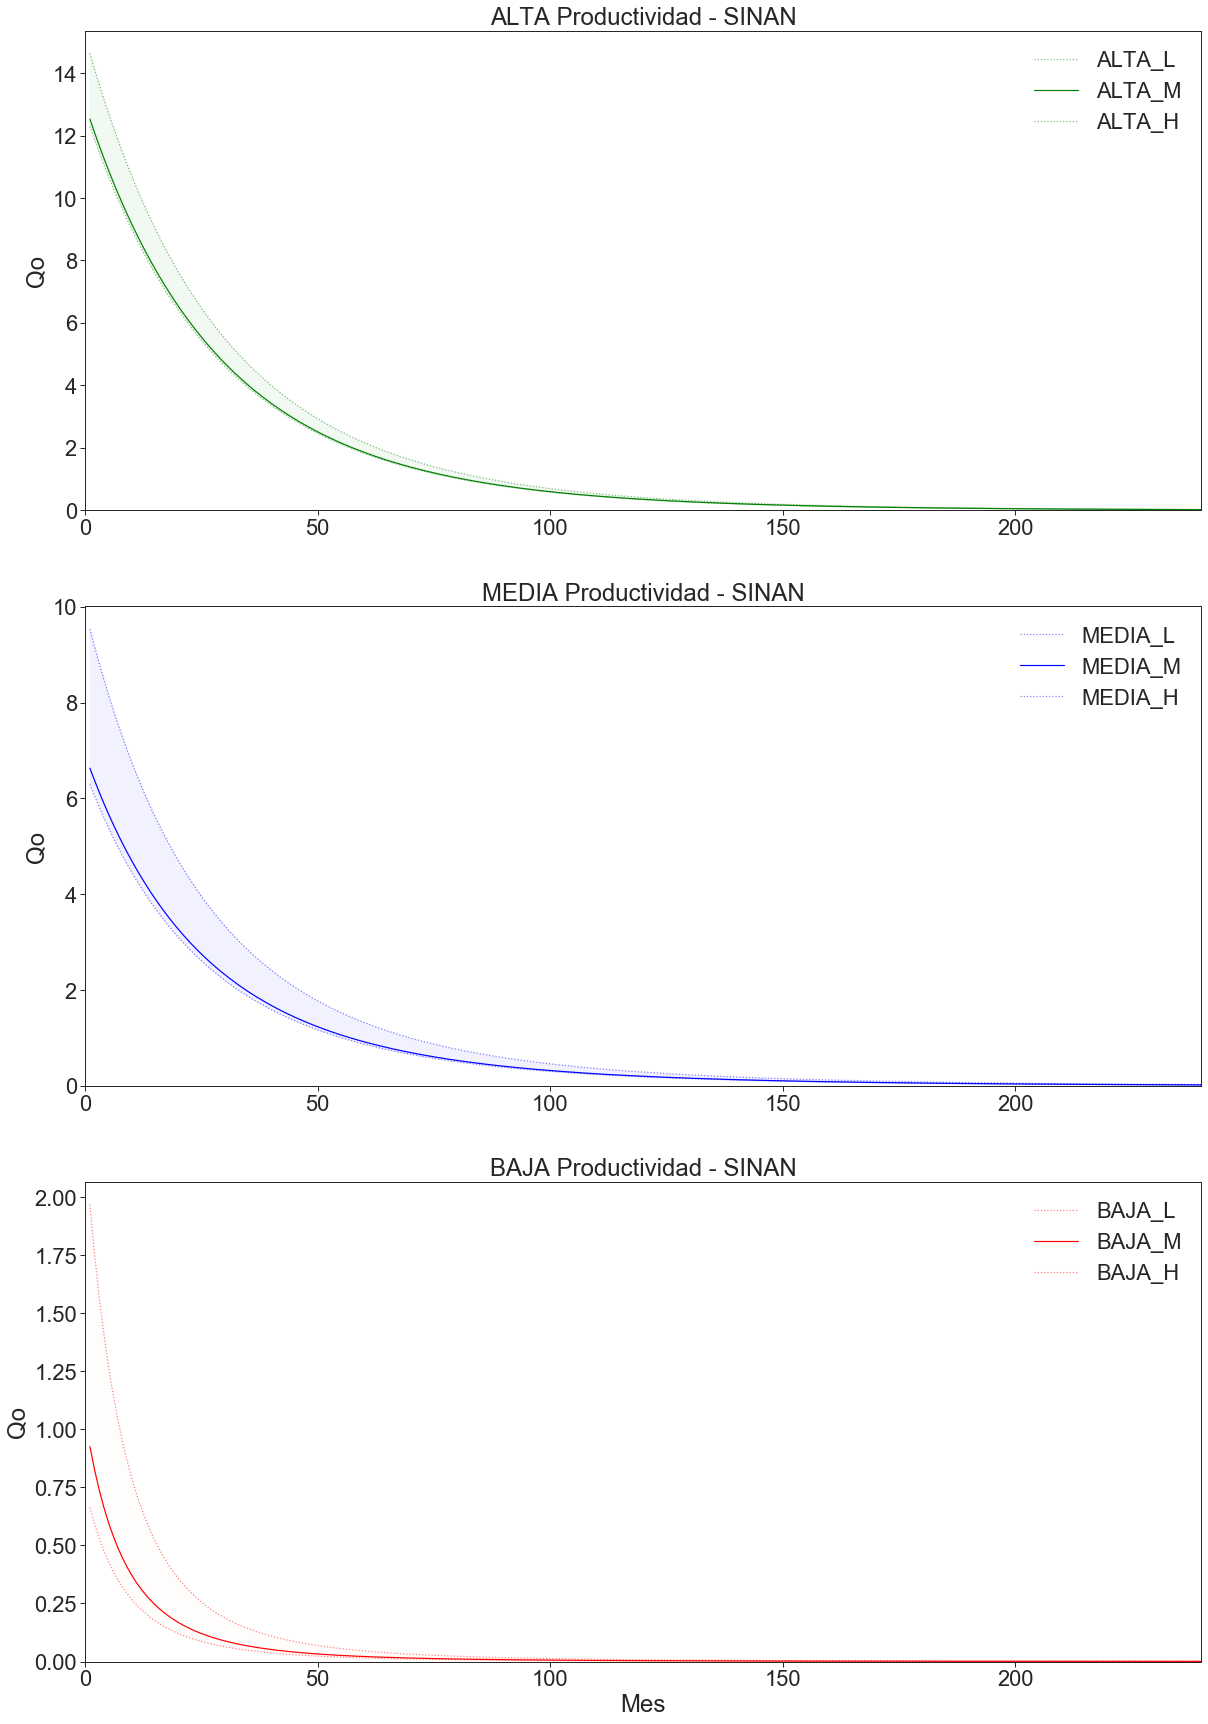

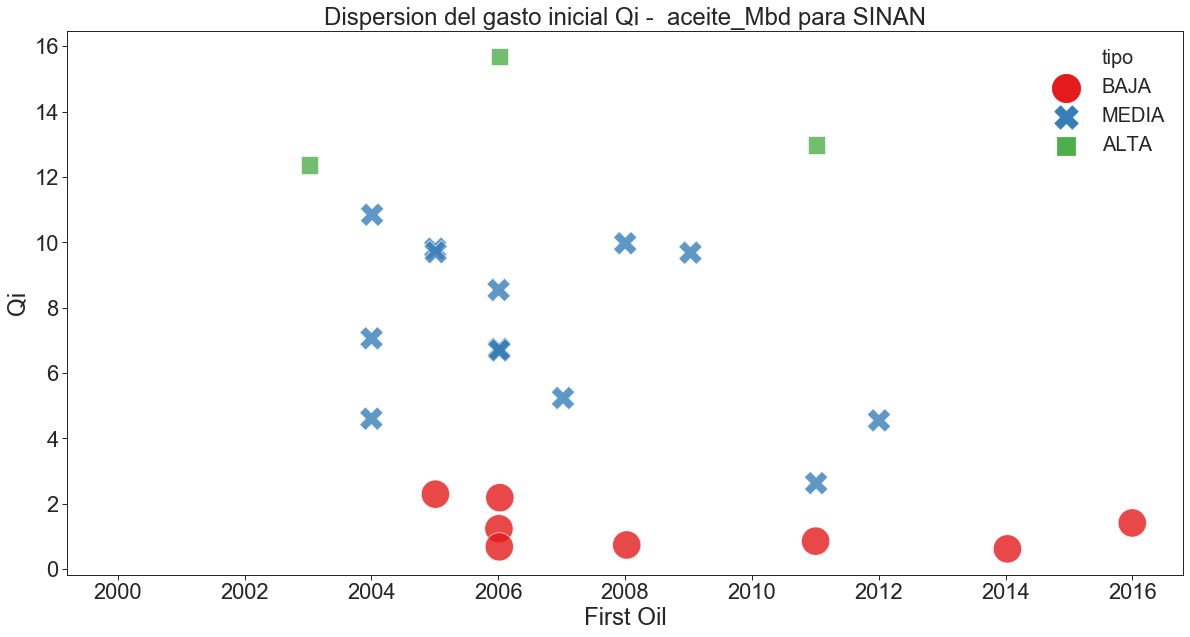

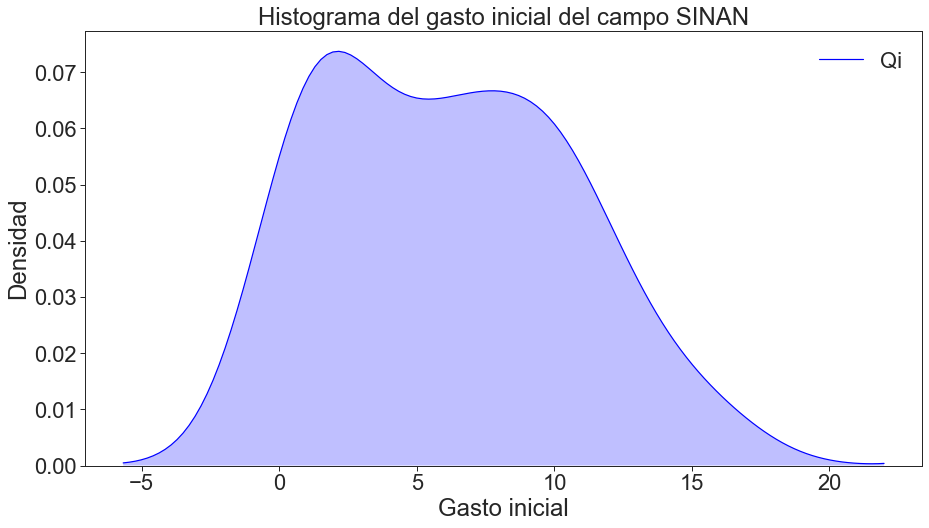

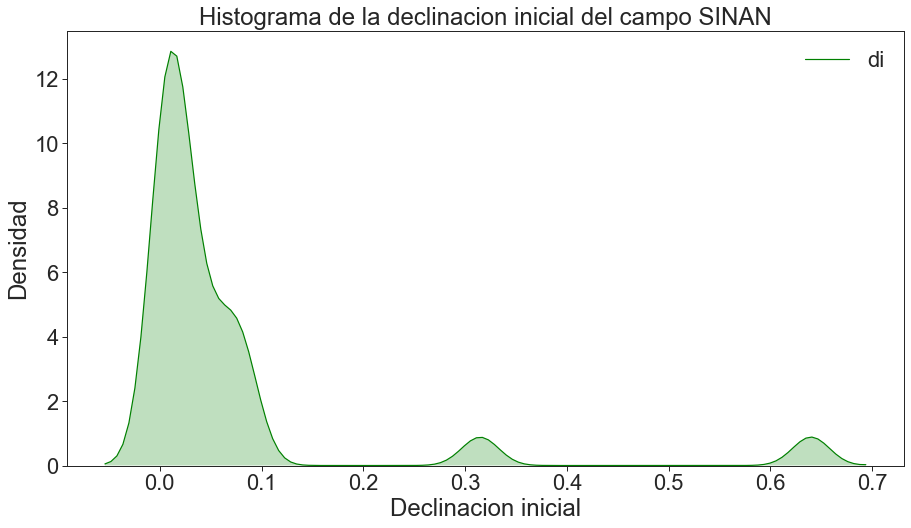

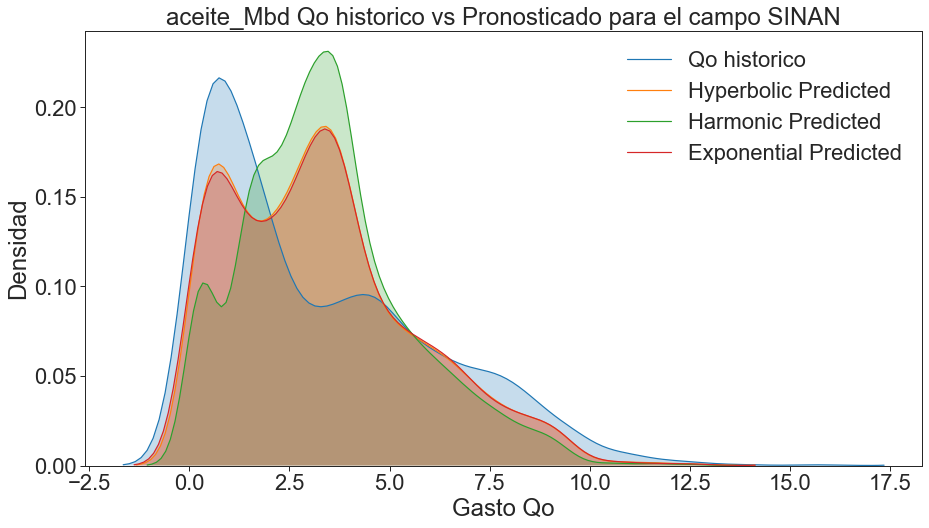

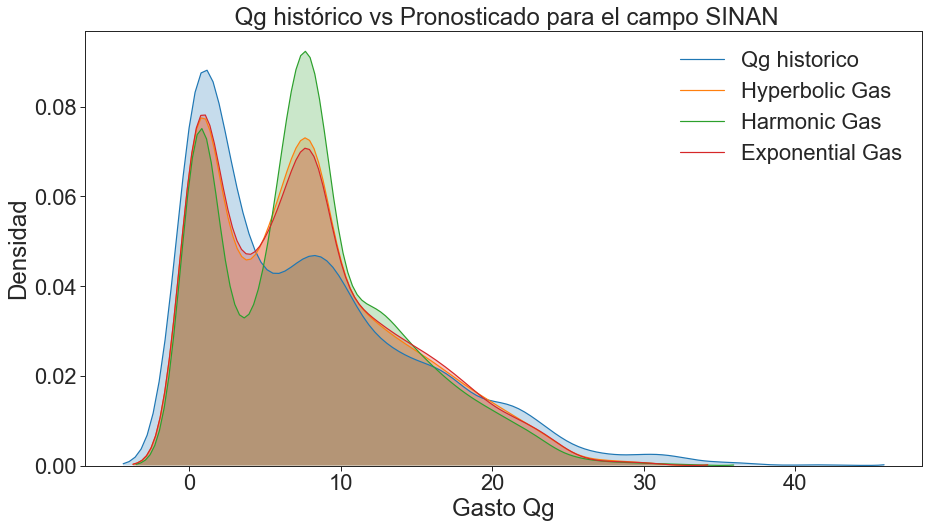

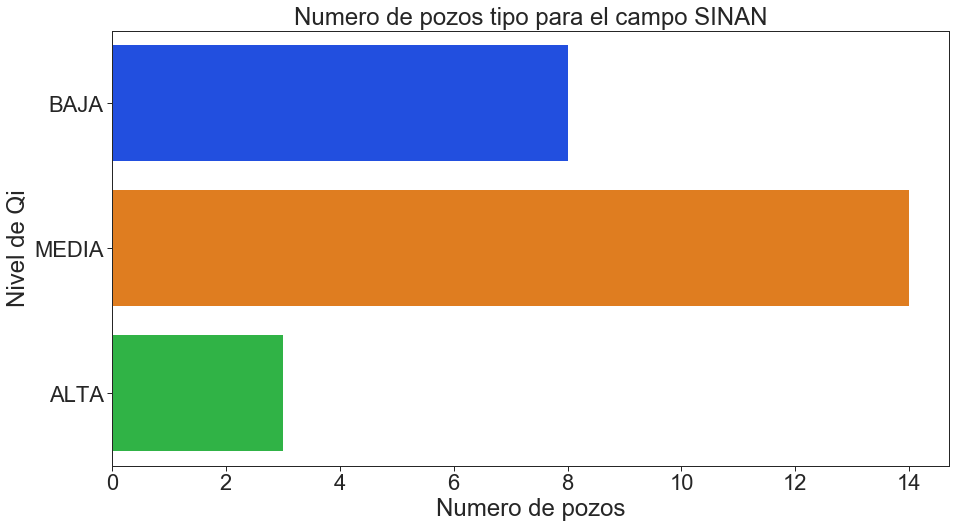

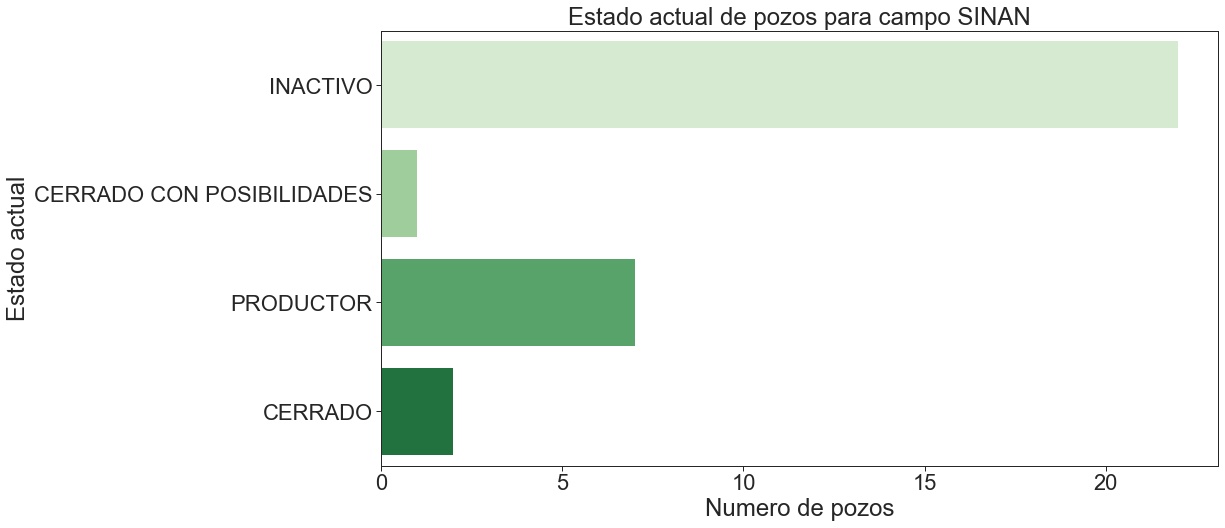

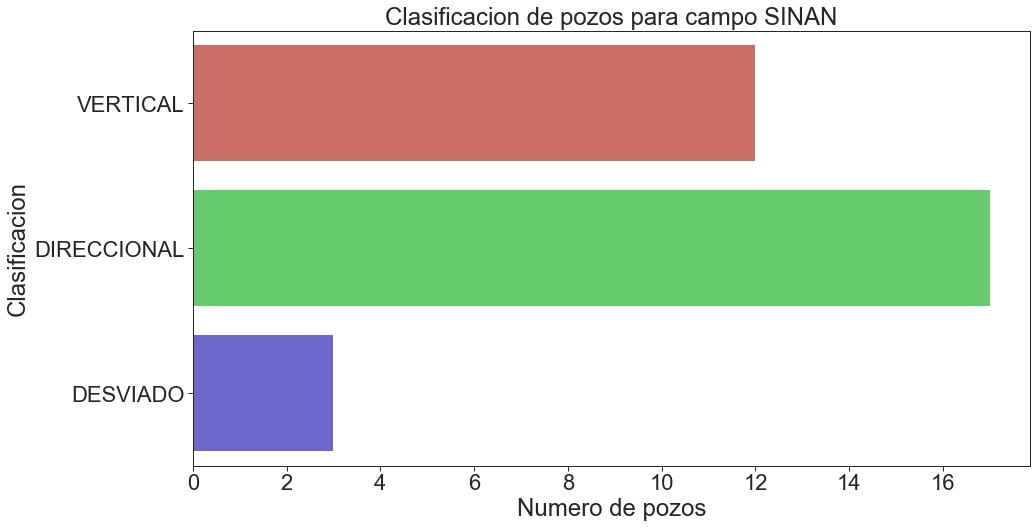

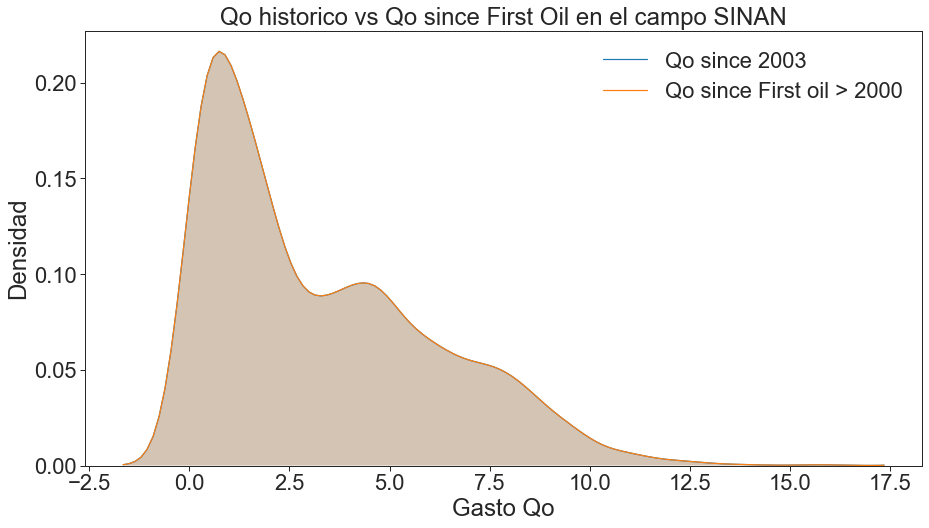

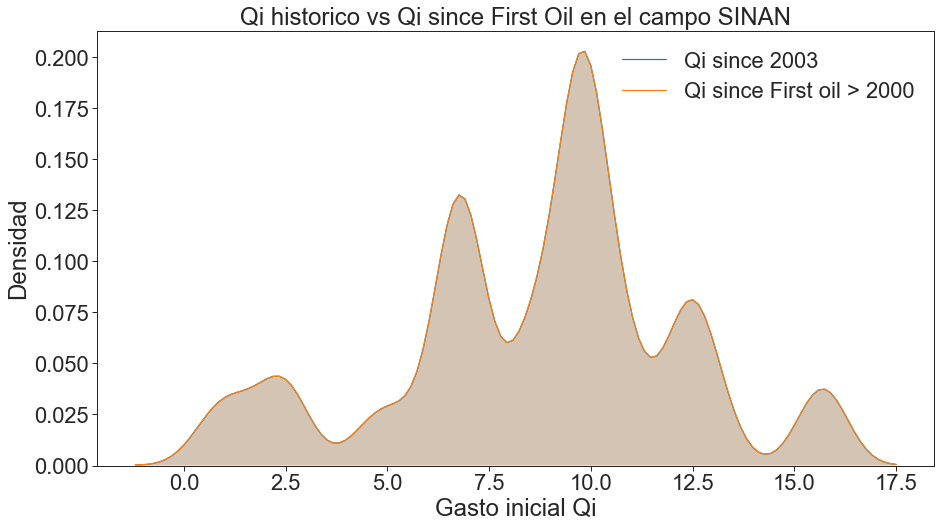

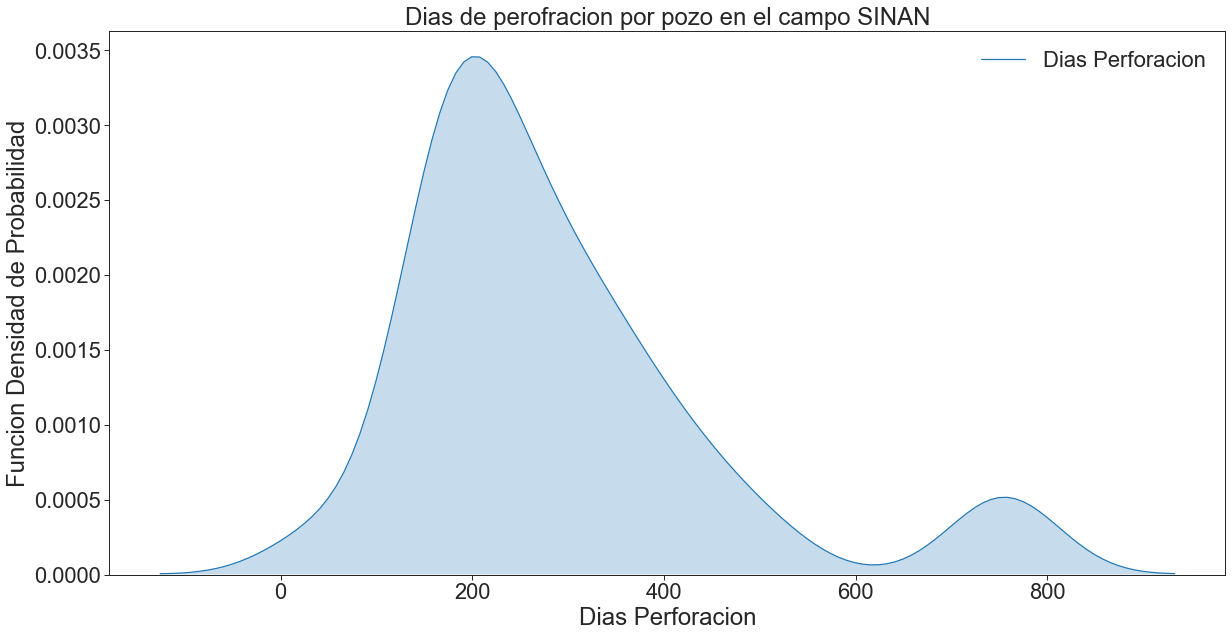

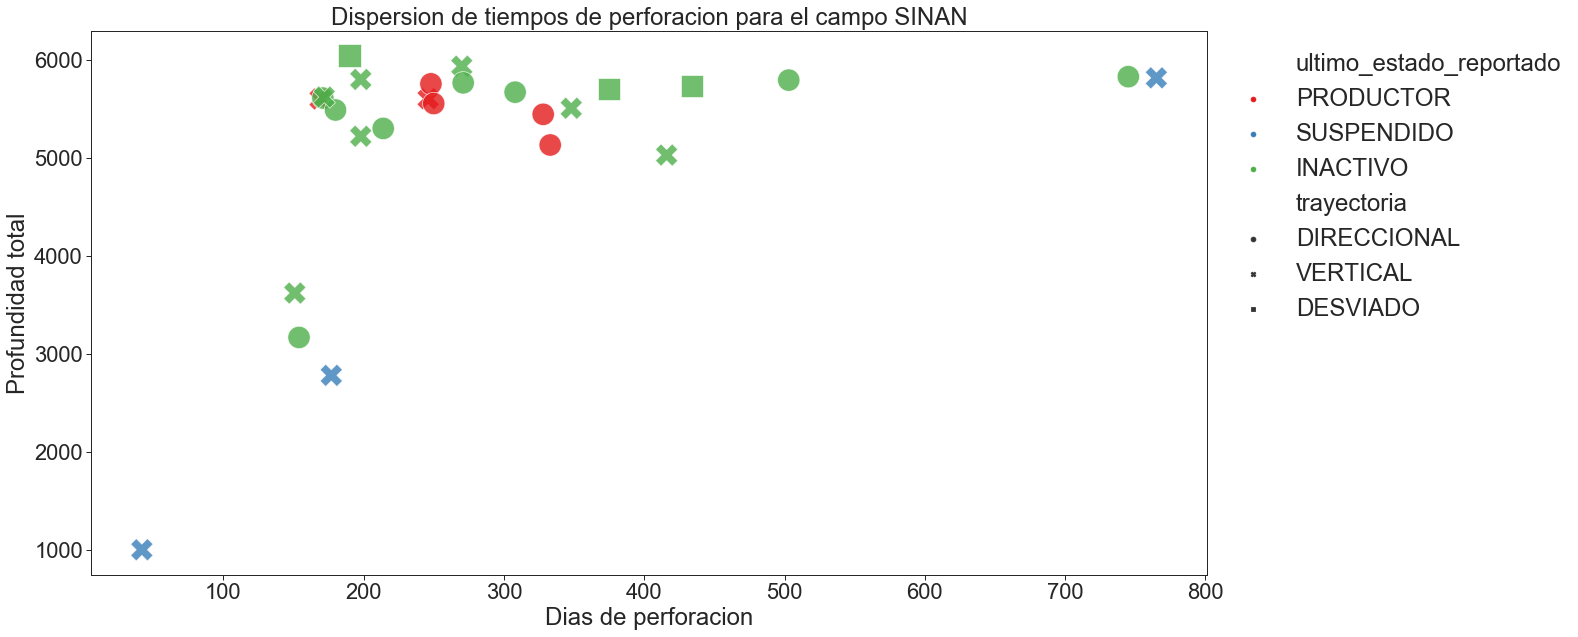

In [14]:
productividad()

In [16]:
display(tipo1.describe(),
       tipo2.describe(),
       tipo3.describe())

Qi_hist  Qi_hyp    b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count     8.00    8.00 8.00    8.00          8.00          8.00     8.00     8.00           8.00           8.00    8.00    8.00          8.00          8.00               8.00     8.00                  5.00    8.00   8.00    8.00           8.00          8.00           8.00
mean      1.25    0.91 0.29    0.12          0.62         23.25     0.92     0.14           0.43           0.17    0.90    0.09          0.38          0.12               0.11    21.88              5,231.80    0.84   0.24    0.10           0.00          0.50           5.00
std       0.67    0.40 0.45    0.21          0.94         63.87     0.41     0.21           0.50           0.17    0.39    0.13          0.52          0.17               0.08    22.39                178.93    0.64   0.45    0.12           0.00          0.00           0.00
min       0.62    0.45 0.00    0.00          0.05          0.00     0.45     0.00           0.12           0.02    0.45    0.00          0.08          0.01               0.02     4.00              5,024.00    0.18   0.00    0.00           0.00          0.50           5.00
25%       0.72    0.56 0.00    0.03          0.13          0.01     0.58     0.04           0.18           0.07    0.56    0.03          0.13          0.03               0.06     9.00              5,148.00    0.51   0.00    0.02           0.00          0.50           5.00
50%       1.04    0.93 0.00    0.06          0.29          0.53     0.92     0.08           0.26           0.08    0.93    0.06          0.21          0.04               0.09    13.50              5,166.00    0.60   0.00    0.08           0.00          0.50           5.00
75%       1.60    1.24 0.50    0.08          0.54          1.49     1.26     0.11           0.38           0.23    1.21    0.08          0.32          0.13               0.19    23.00              5,341.00    0.94   0.24    0.11           0.00          0.50           5.00
max       2.29    1.41 1.00    0.64          2.88        181.30     1.41     0.64           1.64           0.51    1.41    0.39          1.64          0.50               0.25    68.00              5,480.00    2.12   1.00    0.36           0.00          0.50           5.00

Qi_hist  Qi_hyp     b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count    14.00   14.00 14.00   14.00         14.00         14.00    14.00    14.00          14.00          14.00   14.00   14.00         14.00         14.00              14.00    14.00                 14.00   14.00  14.00   14.00          14.00         14.00          14.00
mean      7.34    6.17  0.16    0.04          0.42          0.82     6.22     0.05           0.56           0.02    6.11    0.02          0.38          0.01               0.54   102.36              5,129.67   14.19   0.12    0.02           0.00          0.50           5.00
std       2.49    2.67  0.36    0.08          0.17          2.54     2.71     0.08           0.21           0.03    2.73    0.03          0.13          0.01               0.84    51.34              1,492.82    9.25   0.31    0.02           0.00          0.00           0.00
min       2.63    1.79  0.00    0.00          0.24          0.00     1.78     0.00           0.24           0.00    1.79    0.00          0.22          0.00               0.02    18.00                 44.00    0.38   0.00    0.00           0.00          0.50           5.00
25%       5.60    3.99  0.00    0.01          0.32          0.03     3.92     0.02           0.38           0.00    3.99    0.01          0.32          0.00               0.09    60.75              5,387.50    8.51   0.00    0.01           0.00          0.50           5.00
50%       6.90    6.85  0.00    0.02          0.36          0.08     6.88     0.02           0.60           0.01    6.85    0.02          0.35          0.00               0.15   108.00              5,598.50   14.68   0.00    0.01           0.00          0.50           5.00
75%       9.69    7.97  0.00    0.02          0.44          0.27     8.14     0.04           0.64           0.01    7.93    0.02          0.42          0.00               0.61   141.75              5,623.30   20.60   0.00    0.02           0.00          0.50           5.00
max      10.84    9.69  1.00    0.31          0.80          9.61     9.69     0.32           1.03           0.08    9.69    0.11          0.69          0.04               3.15   176.00              5,935.00   31.18   1.00    0.09           0.00          0.50           5.00

Qi_hist  Qi_hyp    b  di_hyp  error_Qi_hyp  error_di_hyp  Qi_harm  di_harm  error_Qi_harm  error_di_harm  Qi_exp  di_exp  error_Qi_exp  error_di_exp  ultima_produccion  mes_max  profundidad_vertical  Qi_gas  b_gas  di_gas  Qi_condensado  b_condensado  di_condensado
count     3.00    3.00 3.00    3.00          3.00          3.00     3.00     3.00           3.00           3.00    3.00    3.00          3.00          3.00               3.00     3.00                  3.00    3.00   3.00    3.00           3.00          3.00           3.00
mean     13.68   11.58 0.09    0.04          0.78          0.11    11.96     0.07           1.15           0.01   11.36    0.03          0.61          0.00               0.54   127.00              3,672.00   19.02   0.13    0.03           0.00          0.50           5.00
std       1.77    1.94 0.15    0.03          0.32          0.10     2.35     0.05           0.54           0.01    1.90    0.02          0.17          0.00               0.37    60.56              3,141.99   13.19   0.23    0.02           0.00          0.00           0.00
min      12.36    9.45 0.00    0.01          0.42          0.01     9.28     0.01           0.55           0.00    9.45    0.01          0.42          0.00               0.15    74.00                 44.00    4.01   0.00    0.00           0.00          0.50           5.00
25%      12.67   10.75 0.00    0.02          0.65          0.06    11.13     0.05           0.93           0.01   10.41    0.02          0.55          0.00               0.36    94.00              2,756.50   14.15   0.00    0.01           0.00          0.50           5.00
50%      12.98   12.05 0.00    0.04          0.89          0.11    12.98     0.08           1.31           0.02   11.38    0.04          0.69          0.00               0.57   114.00              5,469.00   24.29   0.00    0.02           0.00          0.50           5.00
75%      14.34   12.65 0.13    0.05          0.96          0.16    13.30     0.10           1.45           0.02   12.32    0.04          0.71          0.00               0.73   153.50              5,486.00   26.53   0.20    0.04           0.00          0.50           5.00
max      15.69   13.25 0.26    0.06          1.04          0.21    13.63     0.11           1.59           0.02   13.26    0.05          0.73          0.00               0.90   193.00              5,503.00   28.76   0.40    0.05           0.00          0.50           5.00

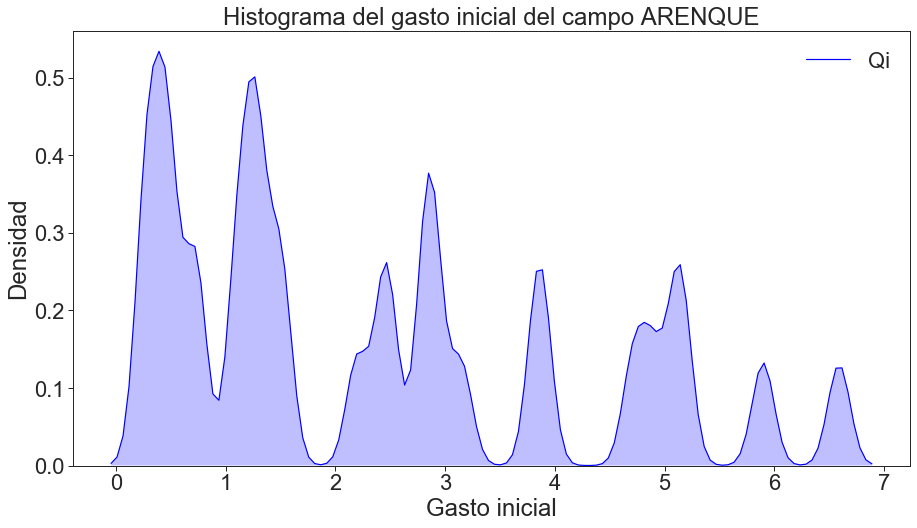

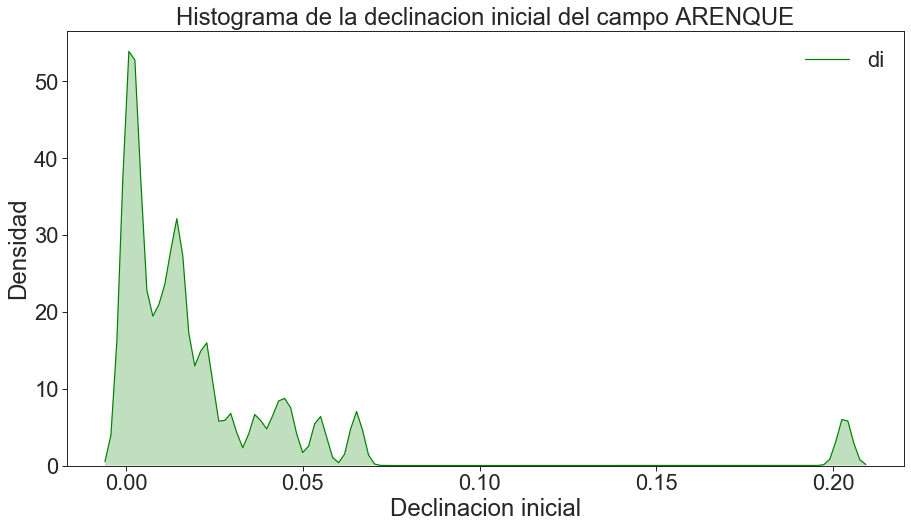

In [12]:
fig0, ax0 = plt.subplots(figsize=(15,8))  

sns.distplot(gasto.Qi_hist, hist=False, kde=True,label='Qi',color='Blue', kde_kws = {'shade': True, 'bw':0.1})
ax0.set_xlabel('Gasto inicial')
ax0.set_ylabel('Densidad')
plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
plt.legend(loc='best')

fig1, ax1 = plt.subplots(figsize=(15,8))  
sns.distplot(gasto.di_hyp, hist=False, kde=True,label='di',color='Green', kde_kws = {'shade': True,'bw':0.002})
ax1.set_xlabel('Declinacion inicial')
ax1.set_ylabel('Densidad')
plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
plt.legend(loc='best')

In [13]:
display(estadistica)

aceite_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd  agua_Mbd  condensado_Mbd  ano_de_perforacion  profundidad_total  profundidad_vertical  days_online  dias_perforacion  declinacion  Qi_hist      mes  exponencial  hiperbolica  harmonica  gas_hiperbolica  gas_harmonica  gas_exponencial  condensado
count    9,808.00            9,808.00               9,808.00  9,808.00        9,808.00            9,808.00           9,808.00              9,808.00     9,808.00              0.00     9,778.00 9,808.00 9,808.00     9,808.00     9,808.00   9,808.00         9,808.00       9,808.00         9,808.00    9,808.00
mean         0.51                1.45                   0.00      0.09            0.00            1,974.33           3,834.11              3,443.06     7,355.24               nan         0.32     2.69   193.37         0.45         0.49       0.50             1.43           1.43             1.36        0.00
std          0.64                1.62                   0.00      0.16            0.00                2.63             257.57                 86.31     4,708.11               nan         6.27     1.80   128.43         0.56         0.55       0.53             1.26           1.26             1.27        0.00
min          0.00                0.00                   0.00      0.00            0.00            1,970.00           3,463.00              3,364.00         0.00               nan        -0.99     0.25     1.00         0.00         0.04       0.04             0.02           0.03             0.00        0.00
25%          0.15                0.26                   0.00      0.00            0.00            1,972.00           3,640.00              3,403.00     3,285.00               nan        -0.03     1.26    83.00         0.10         0.17       0.17             0.39           0.39             0.34        0.00
50%          0.30                0.76                   0.00      0.02            0.00            1,974.00           3,770.00              3,427.00     6,943.00               nan         0.00     2.48   179.00         0.30         0.32       0.35             0.98           0.97             0.84        0.00
75%          0.64                2.21                   0.00      0.11            0.00            1,977.00           3,950.00              3,442.00    11,315.00               nan         0.01     3.86   288.00         0.60         0.57       0.60             2.34           2.34             2.11        0.00
max          6.59               10.63                   0.00      1.28            0.00            1,978.00           4,392.50              3,870.00    18,254.00               nan       363.76     6.59   554.00         4.79         5.12       5.70             5.60           5.60             4.95        0.00